# Libraries importing

In [7]:
import csv
from datetime import date
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from statistics import mean
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import linalg
from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape

# Data loading

In [10]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load the CSV file
file_path= '/content/drive/My Drive/shap_experiment/data'
df_processed_combined_data_daily = pd.read_csv(file_path+"/processed_combined_imputed_with_neighbors_df_processed_combined_data_daily.csv")

#df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)
df_processed_combined_data_daily.DateTime = pd.to_datetime(df_processed_combined_data_daily.DateTime)
df_PM10_daily = df_processed_combined_data_daily[['DateTime','Bjelave_PM10']]

Mounted at /content/drive


# Feature Engineering

In [11]:
def add_all_time_features(df, datetime_col='DateTime', target_col='Bjelave_PM10'):
    df_dt=df.copy()
    df_dt['Day'] = df[datetime_col].dt.day.astype(np.float64)               # 1.0, 2.0, ..., 31.0
    df_dt['Month'] = df[datetime_col].dt.month.astype(np.float64)           # 1.0, 2.0, ..., 12.0
    df_dt['Year'] = df[datetime_col].dt.year.astype(np.float64)
    #df['Week_of_Year'] = df[datetime_col].dt.isocalendar().week.astype(np.float64) # 1.0, ..., 52.0
    return df_dt

In [12]:
df_processed_combined_data_daily_dt = add_all_time_features(
    df=df_processed_combined_data_daily
)

In [13]:
df_processed_combined_data_daily_dt.shape

(1826, 15)

In [14]:
df_processed_combined_data_daily.shape

(1826, 12)

# Dataset Splitting

In [15]:
import matplotlib.pyplot as plt
def train_test_split(df, date):
    df = df.copy()
    train_data = df[df['DateTime'] < date].copy()
    test_data = df[df['DateTime'] >= date].copy() # df.DateTime = df.DateTime.dt.strftime('%d/%m/%Y %H:%M')
    return train_data, test_data

def train_test_split_from_to(df, start_date, end_date, slice_date):
    df = df.copy()
    train_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < slice_date)].copy()
    test_data = df[(df['DateTime'] >= slice_date) & (df['DateTime'] <= end_date)].copy()
    return train_data, test_data

def plot_train_test_data(train_data, test_data, date_column, label):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data')
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data')
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(label + ' Train and Test Data')
    plt.legend()
    plt.show()

In [16]:
def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(10,6))
    plt.boxplot(error)
    plt.show()

In [17]:
df_processed_combined_data_daily

,DateTime,wind_speed,wind_direction,precipitation,pressure,temperature,humidity,visibility,cloudiness,Bjelave_PM10,Bjelave_SO2,Bjelave_NO2
0,2018-01-01,1.876859,188.675592,0.012500,940.004167,3.316667,83.500000,17358.823529,7.117647,51.293265,20.956605,34.174856
1,2018-01-02,1.876859,188.675592,0.495833,936.579167,3.541667,93.041667,11216.666667,8.000000,51.293265,27.324796,37.907709
2,2018-01-03,1.876859,188.675592,0.187500,937.400000,3.237500,77.541667,12737.500000,7.112500,61.345475,19.669382,30.834321
3,2018-01-04,1.876859,188.675592,0.000000,935.770833,1.304167,91.500000,11312.500000,6.233333,41.241054,21.401833,31.298637
4,2018-01-05,1.876859,188.675592,0.000000,937.583333,5.183333,74.416667,18941.666667,5.520833,44.815521,20.001500,31.914025
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2022-12-27,2.029167,125.375000,0.479167,948.729167,7.879167,79.666667,18579.166667,6.358333,26.714598,22.752038,26.175499
1822,2022-12-28,1.450000,179.125000,0.000000,949.583333,4.591667,82.208333,19416.666667,4.937500,29.372987,23.098171,32.184576
1823,2022-12-29,2.187500,146.166667,0.000000,947.341667,5.354167,81.666667,18812.500000,4.187500,50.187371,25.431842,38.493039
1824,2022-12-30,1.070833,159.541667,0.000000,947.279167,6.429167,79.083333,19416.666667,4.000000,67.841704,27.591008,54.974991


In [18]:
#input window = 7
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=25)
train_data_combined_ws_week, test_data_combined_ws_week = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_week, test_PM10_daily_ws_week = train_test_split(df_PM10_daily, date)

train_data_combined_ws_week_dt, test_data_combined_ws_week_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 15 #i isti look back
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=45)
train_data_combined_ws_fifteen, test_data_combined_ws_fifteen = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_fifteen, test_PM10_daily_ws_fifteen = train_test_split(df_PM10_daily, date)

train_data_combined_ws_fifteen_dt, test_data_combined_ws_fifteen_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 30
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=60)
train_data_combined_ws_thirty, test_data_combined_ws_thirty = train_test_split(df_processed_combined_data_daily, date) #
train_PM10_daily_ws_thirty, test_PM10_daily_ws_thirty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_thirty_dt, test_data_combined_ws_thirty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 60
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=120)
train_data_combined_ws_sixty, test_data_combined_ws_sixty = train_test_split(df_processed_combined_data_daily, date)
train_PM10_daily_ws_sixty, test_PM10_daily_ws_sixty = train_test_split(df_PM10_daily, date)

train_data_combined_ws_sixty_dt, test_data_combined_ws_sixty_dt = train_test_split(df_processed_combined_data_daily_dt, date) #

#input window = 90
#promijneiti dane kasnije!
date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=180)
train_data_combined_ws_ninety, test_data_combined_ws_ninety = train_test_split(df_processed_combined_data_daily, date)
train_PM10_daily_ws_ninety, test_PM10_daily_ws_ninety = train_test_split(df_PM10_daily, date)
train_data_combined_ws_ninety_dt, test_data_combined_ws_ninety_dt = train_test_split(df_processed_combined_data_daily_dt, date) #


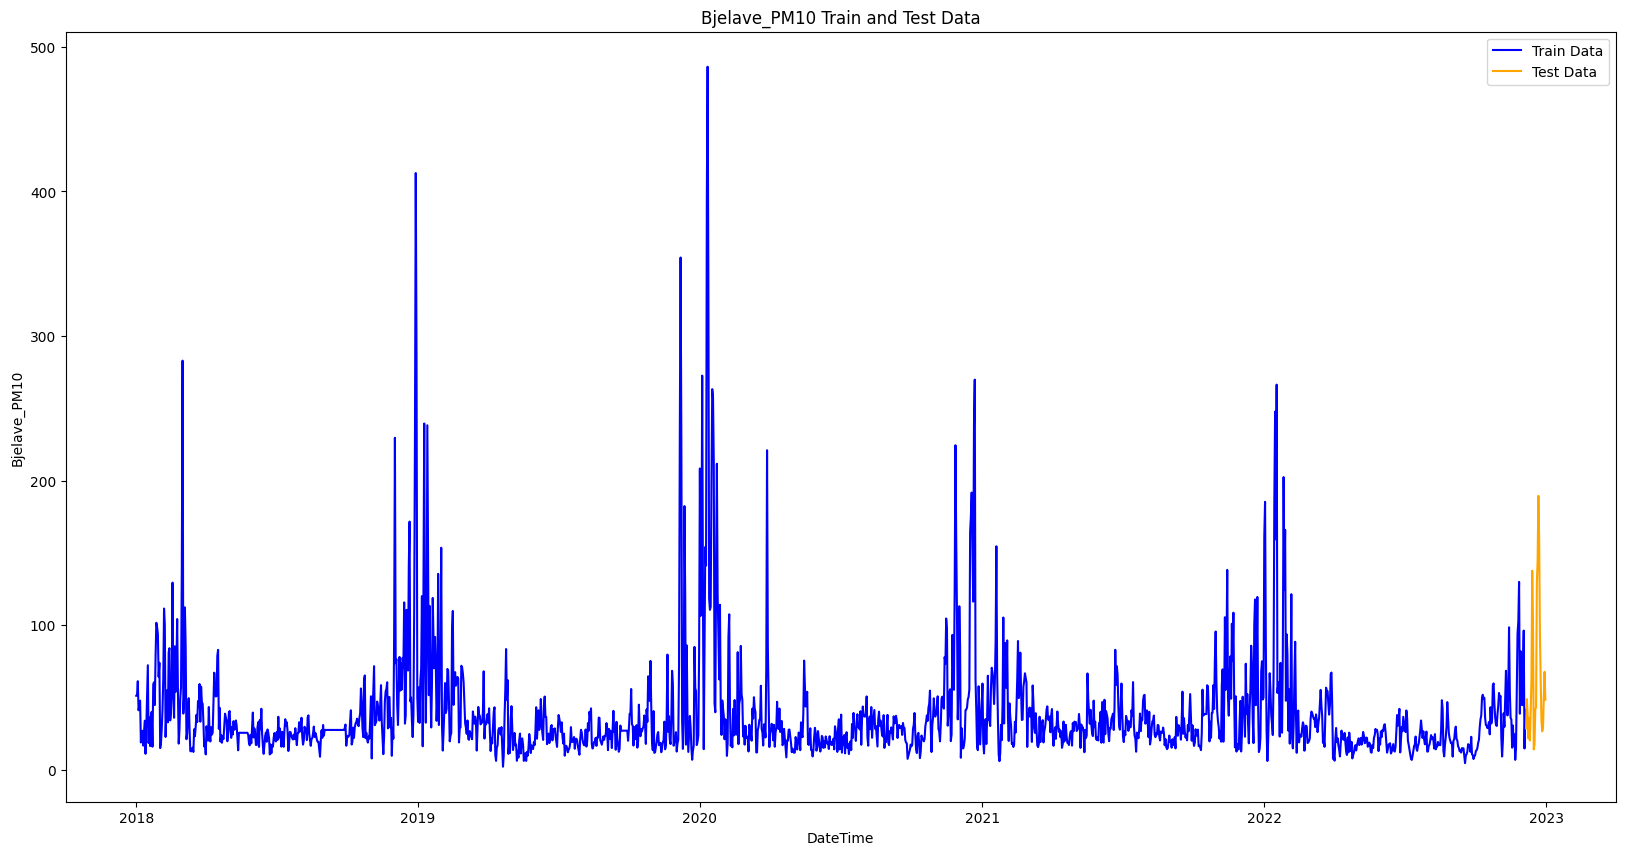

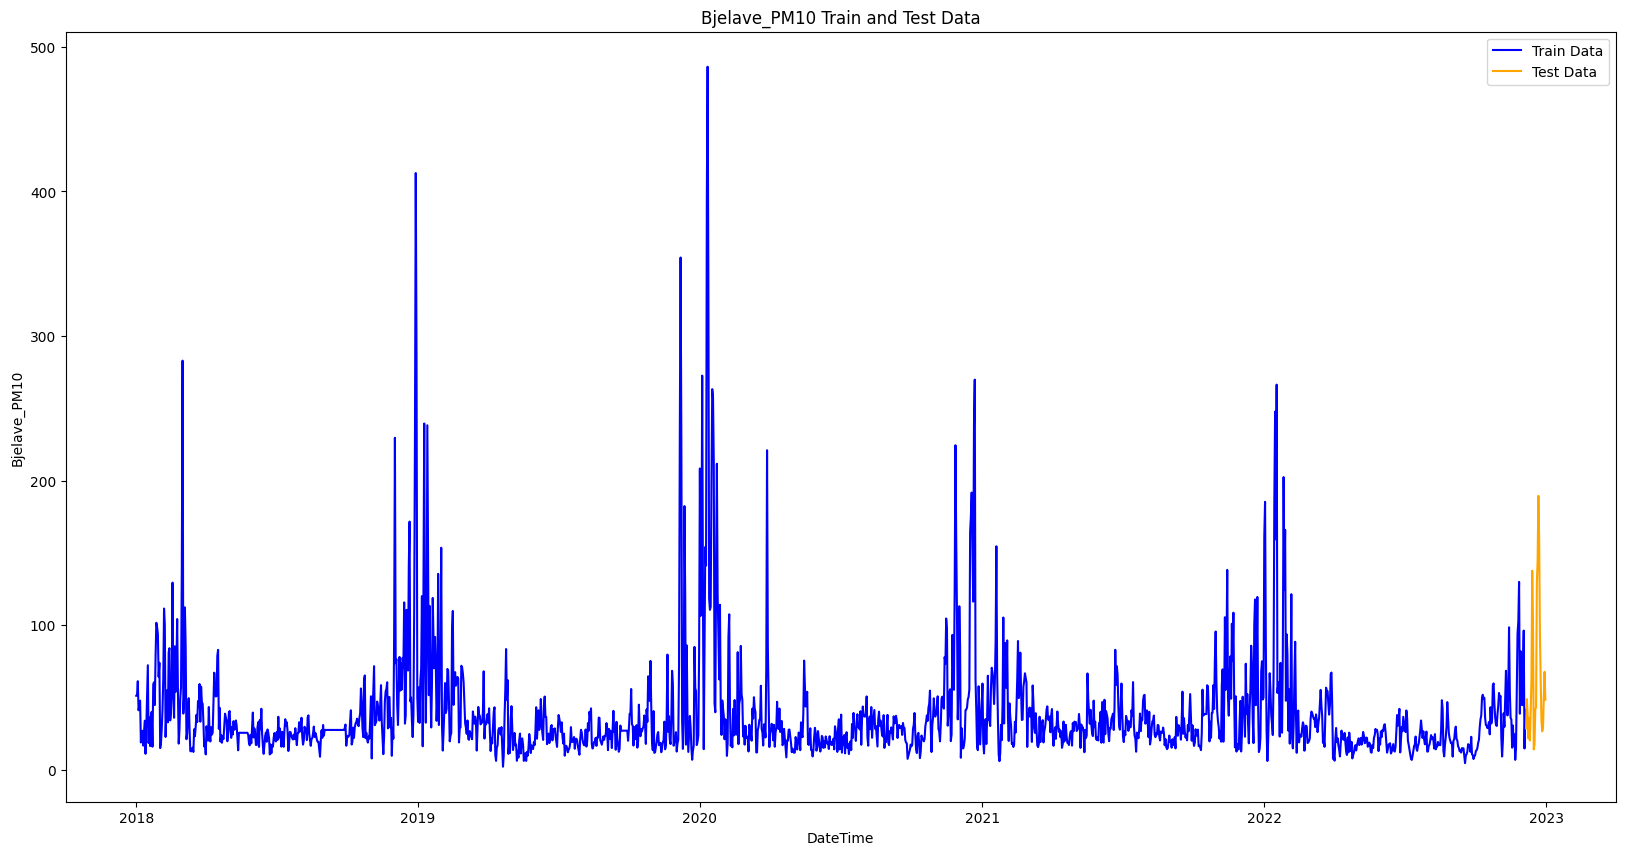

In [19]:
plot_train_test_data(train_data_combined_ws_week, test_data_combined_ws_week, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_week, test_PM10_daily_ws_week, 'DateTime', 'Bjelave_PM10')

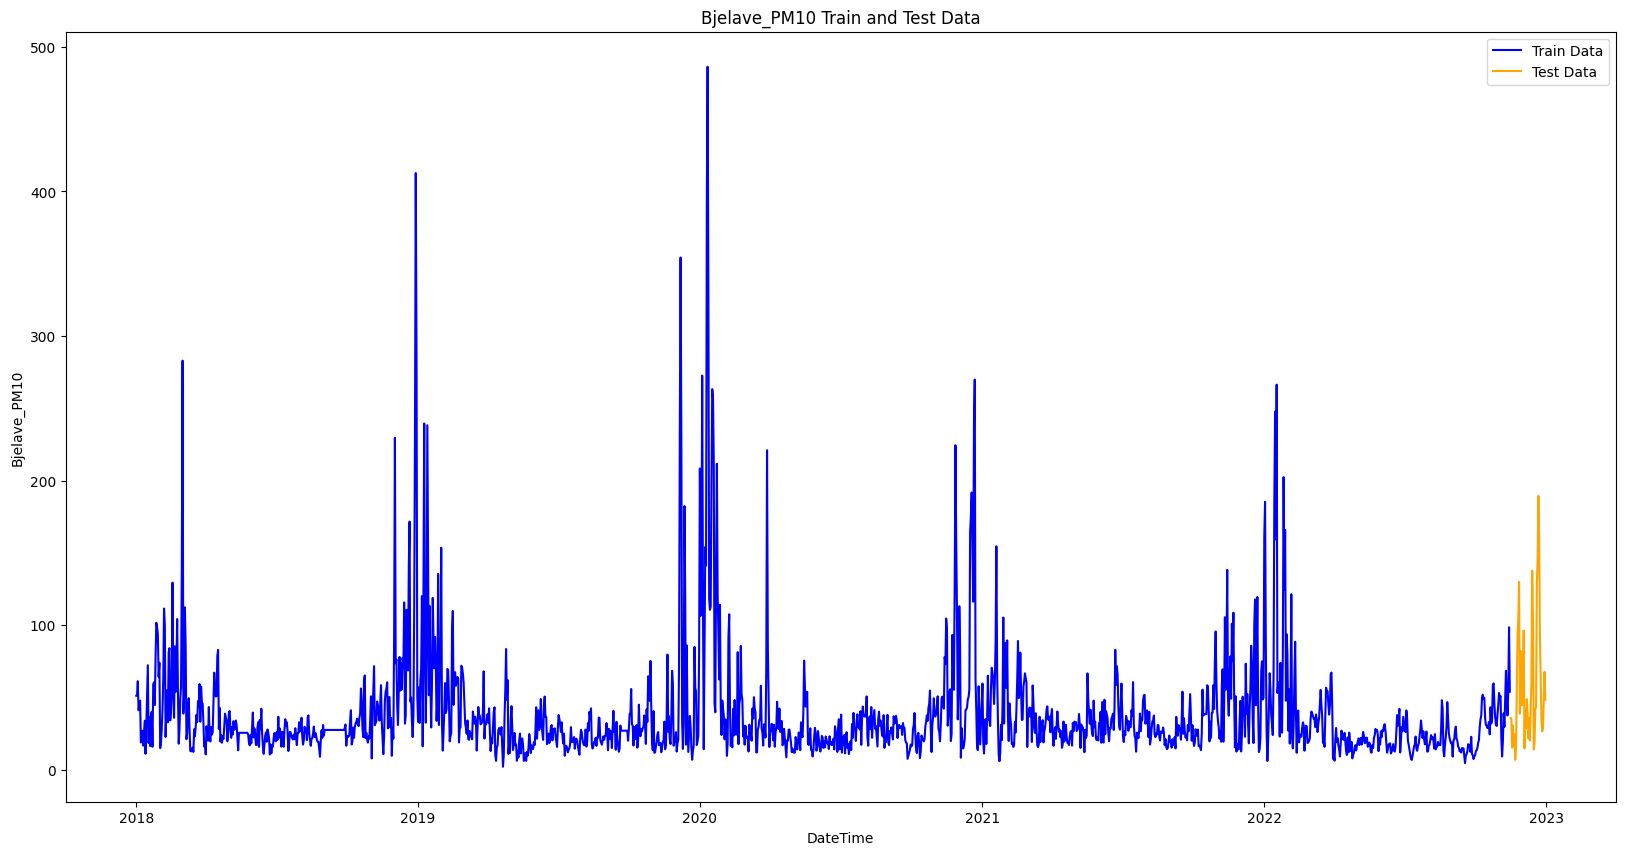

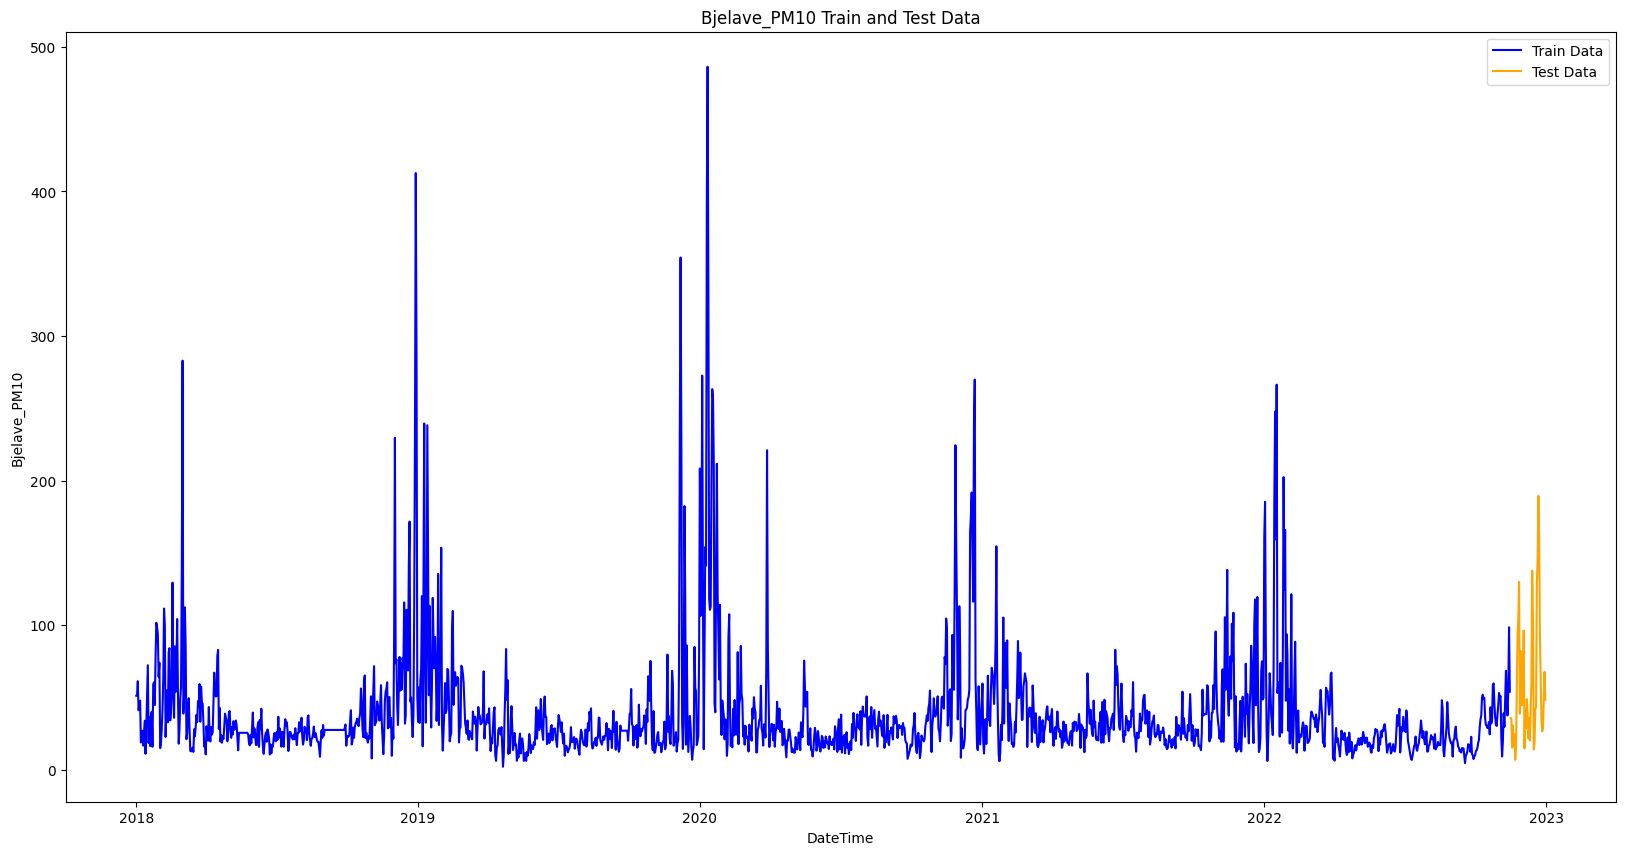

In [20]:
plot_train_test_data(train_data_combined_ws_fifteen, test_data_combined_ws_fifteen, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_fifteen, test_PM10_daily_ws_fifteen, 'DateTime', 'Bjelave_PM10')

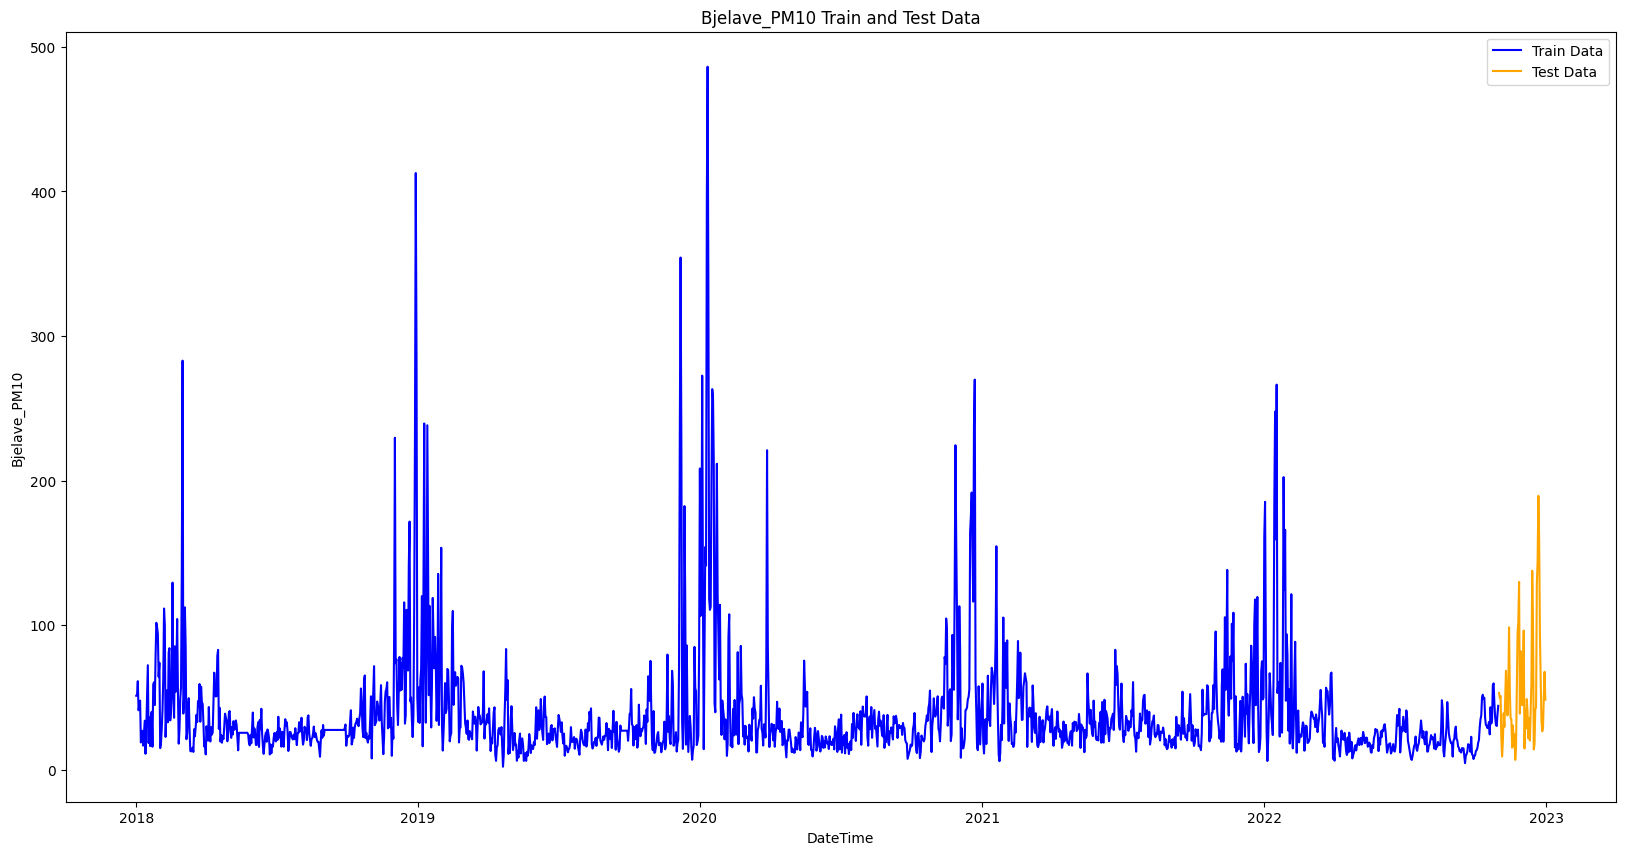

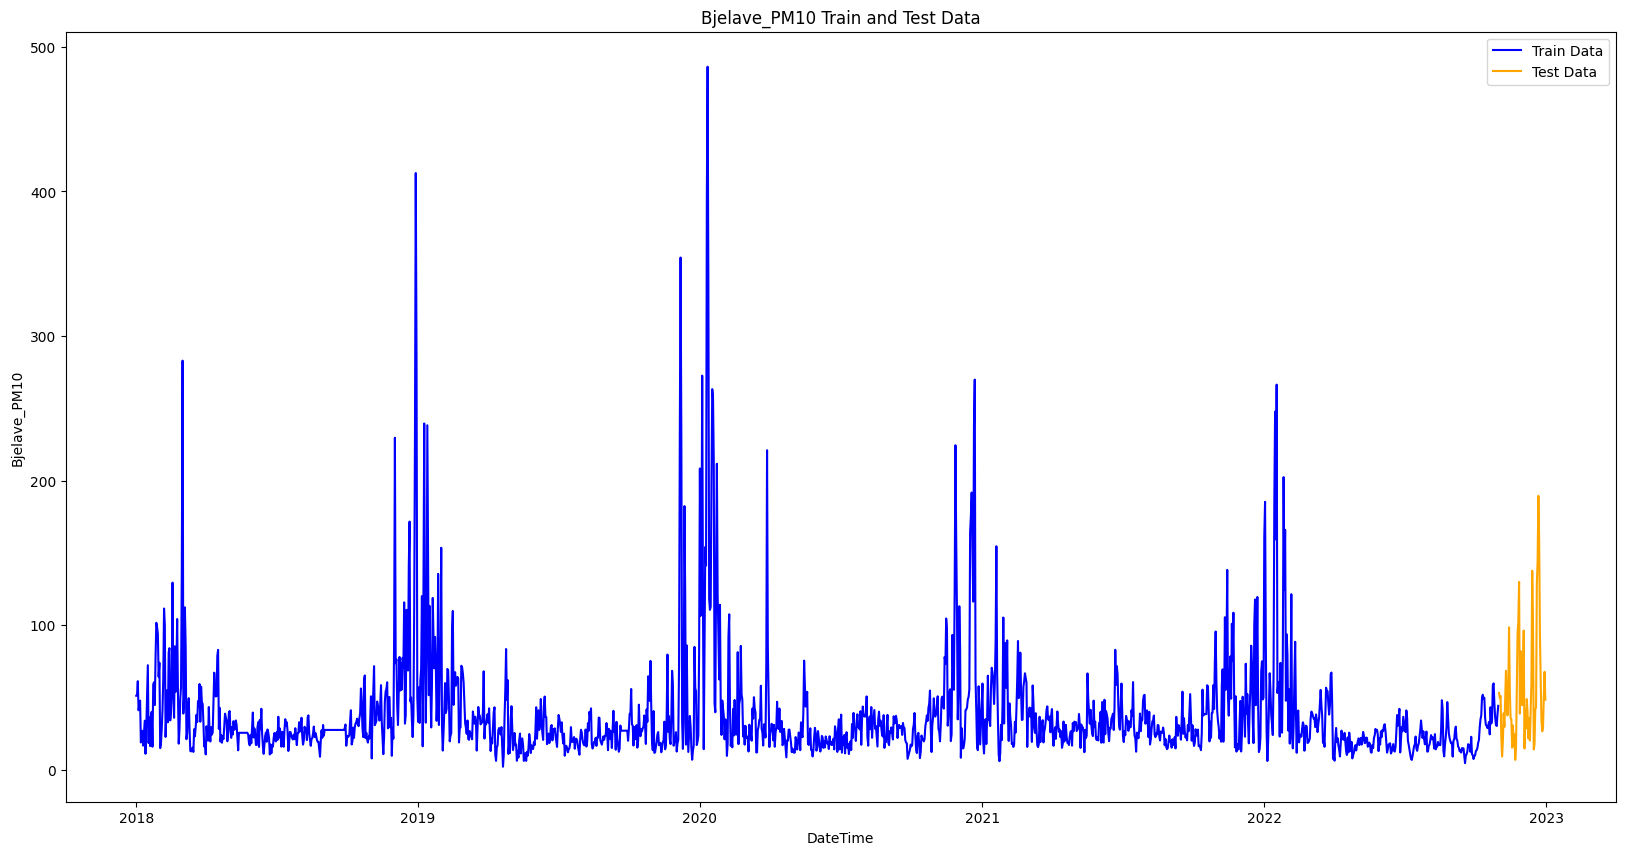

In [21]:
plot_train_test_data(train_data_combined_ws_thirty, test_data_combined_ws_thirty, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_thirty, test_PM10_daily_ws_thirty, 'DateTime', 'Bjelave_PM10')


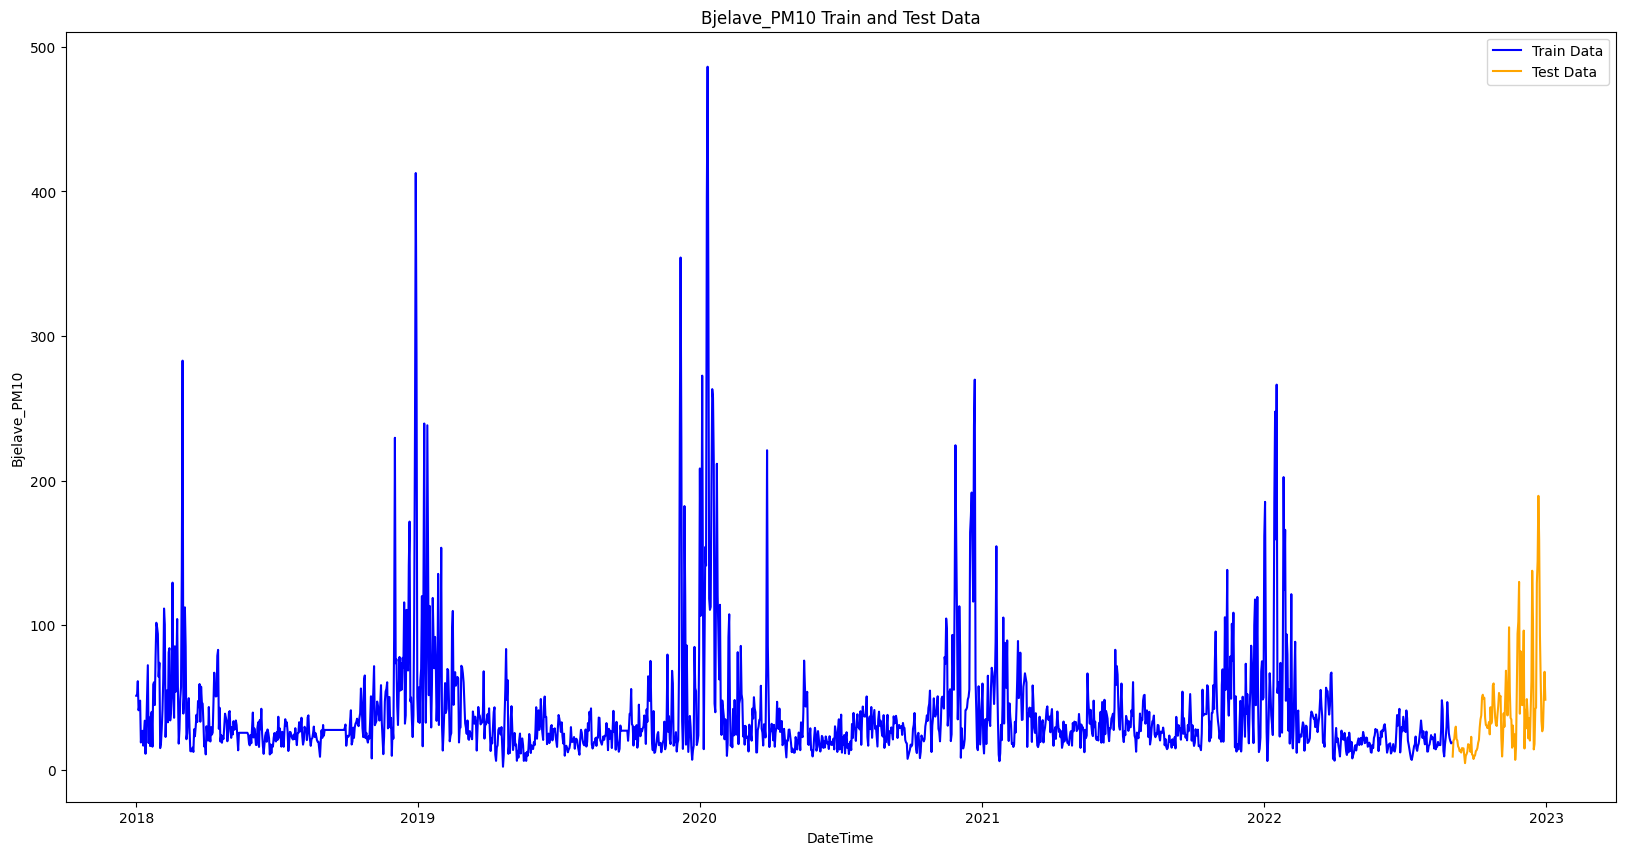

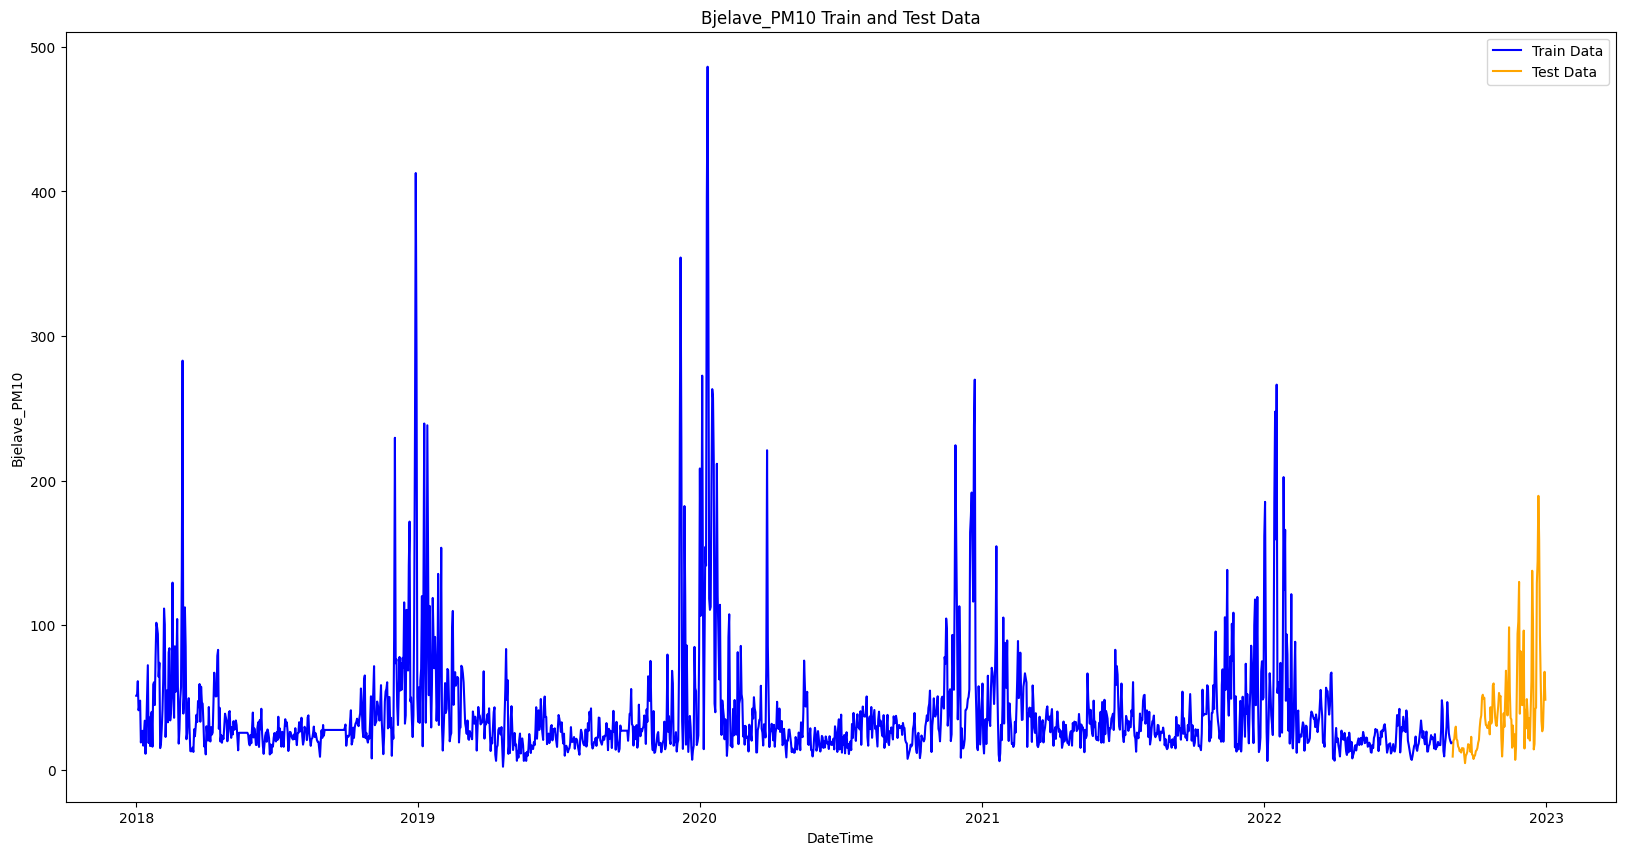

In [22]:
plot_train_test_data(train_data_combined_ws_sixty, test_data_combined_ws_sixty, 'DateTime', 'Bjelave_PM10')
plot_train_test_data(train_PM10_daily_ws_sixty, test_PM10_daily_ws_sixty, 'DateTime', 'Bjelave_PM10')

# Dataset Scaling

In [23]:
from sklearn.preprocessing import MinMaxScaler

train_data_combined_ws_week = train_data_combined_ws_week.set_index('DateTime')
test_data_combined_ws_week = test_data_combined_ws_week.set_index('DateTime')

scaler_data_combined_ws_week = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_week_scaled = scaler_data_combined_ws_week.fit_transform(train_data_combined_ws_week)
test_data_combined_ws_week_scaled = scaler_data_combined_ws_week.transform(test_data_combined_ws_week)


In [24]:
train_data_combined_ws_week_dt = train_data_combined_ws_week_dt.set_index('DateTime')
test_data_combined_ws_week_dt = test_data_combined_ws_week_dt.set_index('DateTime')

scaler_data_combined_ws_week_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_week_scaled_dt = scaler_data_combined_ws_week_dt.fit_transform(train_data_combined_ws_week_dt)
test_data_combined_ws_week_scaled_dt = scaler_data_combined_ws_week_dt.transform(test_data_combined_ws_week_dt)


In [25]:
print(test_data_combined_ws_week.columns.get_loc('Bjelave_PM10'))
index_of_target_feature=test_data_combined_ws_week.columns.get_loc('Bjelave_PM10')
print(test_data_combined_ws_week.columns)

8
Index(['wind_speed', 'wind_direction', 'precipitation', 'pressure',
       'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10',
       'Bjelave_SO2', 'Bjelave_NO2'],
      dtype='object')


In [26]:
test_data_combined_ws_week.shape

(26, 11)

In [27]:
train_data_combined_ws_fifteen_dt = train_data_combined_ws_fifteen_dt.set_index('DateTime')
test_data_combined_ws_fifteen_dt = test_data_combined_ws_fifteen_dt.set_index('DateTime')

scaler_data_combined_ws_fifteen_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_fifteen_scaled_dt = scaler_data_combined_ws_fifteen_dt.fit_transform(train_data_combined_ws_fifteen_dt)
test_data_combined_ws_fifteen_scaled_dt = scaler_data_combined_ws_fifteen_dt.transform(test_data_combined_ws_fifteen_dt)

In [28]:
train_data_combined_ws_fifteen = train_data_combined_ws_fifteen.set_index('DateTime')
test_data_combined_ws_fifteen = test_data_combined_ws_fifteen.set_index('DateTime')

scaler_data_combined_ws_fifteen = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_fifteen_scaled = scaler_data_combined_ws_fifteen.fit_transform(train_data_combined_ws_fifteen)
test_data_combined_ws_fifteen_scaled = scaler_data_combined_ws_fifteen.transform(test_data_combined_ws_fifteen)

In [29]:
train_data_combined_ws_thirty_dt = train_data_combined_ws_thirty_dt.set_index('DateTime')
test_data_combined_ws_thirty_dt = test_data_combined_ws_thirty_dt.set_index('DateTime')

scaler_data_combined_ws_thirty_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_thirty_scaled_dt = scaler_data_combined_ws_thirty_dt.fit_transform(train_data_combined_ws_thirty_dt)
test_data_combined_ws_thirty_scaled_dt = scaler_data_combined_ws_thirty_dt.transform(test_data_combined_ws_thirty_dt)

In [30]:
train_data_combined_ws_thirty = train_data_combined_ws_thirty.set_index('DateTime')
test_data_combined_ws_thirty = test_data_combined_ws_thirty.set_index('DateTime')

scaler_data_combined_ws_thirty = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_thirty_scaled = scaler_data_combined_ws_thirty.fit_transform(train_data_combined_ws_thirty)
test_data_combined_ws_thirty_scaled = scaler_data_combined_ws_thirty.transform(test_data_combined_ws_thirty)

In [31]:
train_data_combined_ws_sixty_dt = train_data_combined_ws_sixty_dt.set_index('DateTime')
test_data_combined_ws_sixty_dt = test_data_combined_ws_sixty_dt.set_index('DateTime')

scaler_data_combined_ws_sixty_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_sixty_scaled_dt = scaler_data_combined_ws_sixty_dt.fit_transform(train_data_combined_ws_sixty_dt)
test_data_combined_ws_sixty_scaled_dt = scaler_data_combined_ws_sixty_dt.transform(test_data_combined_ws_sixty_dt)

In [32]:
train_data_combined_ws_sixty = train_data_combined_ws_sixty.set_index('DateTime')
test_data_combined_ws_sixty = test_data_combined_ws_sixty.set_index('DateTime')

scaler_data_combined_ws_sixty = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_sixty_scaled = scaler_data_combined_ws_sixty.fit_transform(train_data_combined_ws_sixty)
test_data_combined_ws_sixty_scaled = scaler_data_combined_ws_sixty.transform(test_data_combined_ws_sixty)

print("train_data_combined_ws_sixty_scaled.shape :", train_data_combined_ws_sixty_scaled.shape)
print("train_data_combined_ws_sixty.shape :", train_data_combined_ws_sixty.shape)

print("test_data_combined_ws_sixty_scaled.shape :", test_data_combined_ws_sixty_scaled.shape)
print("test_data_combined_ws_sixty.shape :", test_data_combined_ws_sixty.shape)

train_data_combined_ws_sixty_scaled.shape : (1705, 11)
train_data_combined_ws_sixty.shape : (1705, 11)
test_data_combined_ws_sixty_scaled.shape : (121, 11)
test_data_combined_ws_sixty.shape : (121, 11)


In [33]:
train_data_combined_ws_ninety = train_PM10_daily_ws_ninety.set_index('DateTime')
test_data_combined_ws_ninety = test_PM10_daily_ws_ninety.set_index('DateTime')

scaler_data_combined_ws_ninety = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_ninety_scaled = scaler_data_combined_ws_ninety.fit_transform(train_data_combined_ws_ninety)
test_data_combined_ws_ninety_scaled = scaler_data_combined_ws_ninety.transform(test_data_combined_ws_ninety)

In [34]:
train_PM10_daily_ws_week = train_PM10_daily_ws_week.set_index('DateTime')
test_PM10_daily_ws_week = test_PM10_daily_ws_week.set_index('DateTime')

scaler_PM10_daily_ws_week = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_week = scaler_PM10_daily_ws_week.fit_transform(train_PM10_daily_ws_week)
test_PM10_daily_ws_week = scaler_PM10_daily_ws_week.transform(test_PM10_daily_ws_week)

In [35]:
train_PM10_daily_ws_fifteen = train_PM10_daily_ws_fifteen.set_index('DateTime')
test_PM10_daily_ws_fifteen = test_PM10_daily_ws_fifteen.set_index('DateTime')

scaler_PM10_daily_ws_fifteen = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_fifteen = scaler_PM10_daily_ws_fifteen.fit_transform(train_PM10_daily_ws_fifteen)
test_PM10_daily_ws_fifteen = scaler_PM10_daily_ws_fifteen.transform(test_PM10_daily_ws_fifteen)

In [36]:
train_PM10_daily_ws_thirty = train_PM10_daily_ws_thirty.set_index('DateTime')
test_PM10_daily_ws_thirty = test_PM10_daily_ws_thirty.set_index('DateTime')

scaler_PM10_daily_ws_thirty = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_thirty = scaler_PM10_daily_ws_thirty.fit_transform(train_PM10_daily_ws_thirty)
test_PM10_daily_ws_thirty = scaler_PM10_daily_ws_thirty.transform(test_PM10_daily_ws_thirty)

In [37]:
train_PM10_daily_ws_sixty = train_PM10_daily_ws_sixty.set_index('DateTime')
test_PM10_daily_ws_sixty = test_PM10_daily_ws_sixty.set_index('DateTime')

scaler_PM10_daily_ws_sixty = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_sixty = scaler_PM10_daily_ws_sixty.fit_transform(train_PM10_daily_ws_sixty)
test_PM10_daily_ws_sixty = scaler_PM10_daily_ws_sixty.transform(test_PM10_daily_ws_sixty)

In [38]:
train_PM10_daily_ws_ninety = train_PM10_daily_ws_ninety.set_index('DateTime')
test_PM10_daily_ws_ninety = test_PM10_daily_ws_ninety.set_index('DateTime')

scaler_PM10_daily_ws_ninety = MinMaxScaler(feature_range=(0,1))
train_PM10_daily_ws_ninety = scaler_PM10_daily_ws_ninety.fit_transform(train_PM10_daily_ws_ninety)
test_PM10_daily_ws_ninety = scaler_PM10_daily_ws_ninety.transform(test_PM10_daily_ws_ninety)

In [39]:
train_data_combined_ws_ninety_dt = train_data_combined_ws_ninety_dt.set_index('DateTime')
test_data_combined_ws_ninety_dt = test_data_combined_ws_ninety_dt.set_index('DateTime')

scaler_data_combined_ws_ninety_dt = MinMaxScaler(feature_range=(0,1))
train_data_combined_ws_ninety_scaled_dt = scaler_data_combined_ws_ninety_dt.fit_transform(train_data_combined_ws_ninety_dt)
test_data_combined_ws_ninety_scaled_dt = scaler_data_combined_ws_ninety_dt.transform(test_data_combined_ws_ninety_dt)

# LSTM for Univariate Time Series Prediction

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    # plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_dataset(data, look_back=1):
    """
    Create LSTM dataset by splitting the input data into input sequences (X) and corresponding output values (Y).

    Parameters:
    - data: numpy array, input data.
    - look_back: int, number of previous time steps to use as input variables to predict the next time period (default is 1).

    Returns:
    - X: numpy array, input sequences.
    - Y: numpy array, corresponding output values.
    """
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)

def train_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    # x_val = x_train[-50:]
    # y_val = y_train[-50:]
    # x_train = x_train[:-50]
    # y_train = y_train[:-50]
    # history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stop])
    history = model.fit(x_train, y_train, epochs=15, batch_size=5, verbose=1, callbacks=[early_stop])
    return history


In [ ]:

def build_model(look_back, num_features, params):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units2"], return_sequences=True))
	model.add(LSTM(units=params["lstm_units1"], return_sequences=False))
	model.add(Dense(1))
	model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model


In [ ]:
# Prepare input and output for LSTM model
look_back = 3
#x_train, y_train = create_dataset(train_data, look_back)

x_train_PM10_daily_ws_week, y_train_PM10_daily_ws_week = create_dataset(train_PM10_daily_ws_week, look_back)
x_train_PM10_daily_ws_fifteen, y_train_PM10_daily_ws_fifteen = create_dataset(train_PM10_daily_ws_fifteen, look_back)
x_train_PM10_daily_ws_thirty, y_train_PM10_daily_ws_thirty = create_dataset(train_PM10_daily_ws_thirty, look_back)
x_train_PM10_daily_ws_sixty, y_train_PM10_daily_ws_sixty = create_dataset(train_PM10_daily_ws_sixty, look_back)
x_train_PM10_daily_ws_ninety, y_train_PM10_daily_ws_ninety = create_dataset(train_PM10_daily_ws_ninety, look_back)

x_test_PM10_daily_ws_week, y_test_PM10_daily_ws_week = create_dataset(test_PM10_daily_ws_week, look_back)
x_test_PM10_daily_ws_fifteen, y_test_PM10_daily_ws_fifteen = create_dataset(test_PM10_daily_ws_fifteen, look_back)
x_test_PM10_daily_ws_thirty, y_test_PM10_daily_ws_thirty = create_dataset(test_PM10_daily_ws_thirty, look_back)
x_test_PM10_daily_ws_sixty, y_test_PM10_daily_ws_sixty = create_dataset(test_PM10_daily_ws_sixty, look_back)
x_test_PM10_daily_ws_ninety, y_test_PM10_daily_ws_ninety = create_dataset(test_PM10_daily_ws_ninety, look_back)

In [ ]:
x_train_PM10_daily_ws_thirty.shape

(1786, 3)

In [ ]:
# reshape input to be [samples, time steps, features]
#x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
num_features=1
x_train_PM10_daily_ws_week = np.reshape(x_train_PM10_daily_ws_week, (x_train_PM10_daily_ws_week.shape[0], look_back, num_features))
x_train_PM10_daily_ws_fifteen = np.reshape(x_train_PM10_daily_ws_fifteen, (x_train_PM10_daily_ws_fifteen.shape[0], look_back, num_features))
x_train_PM10_daily_ws_thirty = np.reshape(x_train_PM10_daily_ws_thirty, (x_train_PM10_daily_ws_thirty.shape[0], look_back, num_features))
x_train_PM10_daily_ws_sixty = np.reshape(x_train_PM10_daily_ws_sixty, (x_train_PM10_daily_ws_sixty.shape[0], look_back, num_features))
x_train_PM10_daily_ws_ninety = np.reshape(x_train_PM10_daily_ws_ninety, (x_train_PM10_daily_ws_ninety.shape[0], look_back, num_features))

x_test_PM10_daily_ws_week = np.reshape(x_test_PM10_daily_ws_week, (x_test_PM10_daily_ws_week.shape[0], look_back, num_features))
x_test_PM10_daily_ws_fifteen = np.reshape(x_test_PM10_daily_ws_fifteen, (x_test_PM10_daily_ws_fifteen.shape[0], look_back, num_features))
x_test_PM10_daily_ws_thirty = np.reshape(x_test_PM10_daily_ws_thirty, (x_test_PM10_daily_ws_thirty.shape[0], look_back, num_features))
x_test_PM10_daily_ws_sixty = np.reshape(x_test_PM10_daily_ws_sixty, (x_test_PM10_daily_ws_sixty.shape[0], look_back, num_features))
x_test_PM10_daily_ws_ninety = np.reshape(x_test_PM10_daily_ws_ninety, (x_test_PM10_daily_ws_ninety.shape[0], look_back, num_features))

In [ ]:
# Training the model
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
  "dropout": 0.1,
	"lstm_units": 64*2,
	"lstm_units3": 90,
	"lstm_units2": 85,
	"lstm_units1": 85,
	"lstm_units0": 40
}

In [ ]:
x_train_PM10_daily_ws_thirty.shape

(1786, 3, 1)

In [ ]:
y_train_PM10_daily_ws_thirty.shape

(1786,)

**7-Day Prediction Window**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0065 - mean_absolute_error: 0.0466 - root_mean_squared_error: 0.0796
Epoch 2/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0062 - mean_absolute_error: 0.0439 - root_mean_squared_error: 0.0784
Epoch 3/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0049 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0698
Epoch 4/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0046 - mean_absolute_error: 0.0350 - root_mean_squared_error: 0.0667
Epoch 5/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0034 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0581
Epoch 6/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0040 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0625
Epoch 7/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0035 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0585
Epoch 8/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0041 - mean_

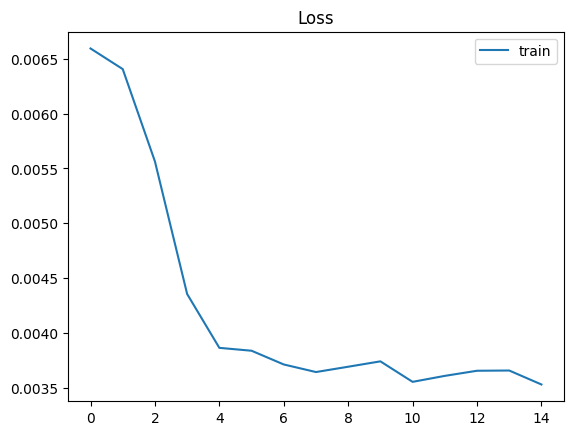

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_week, y_train_PM10_daily_ws_week)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_56 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_week_scaled = model.predict(x_test_PM10_daily_ws_week)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
testPredict_PM10_daily_ws_week = scaler_PM10_daily_ws_week.inverse_transform(testPredict_PM10_daily_ws_week_scaled)

In [ ]:
y_test_PM10_daily_ws_week_unscaled = scaler_PM10_daily_ws_thirty.inverse_transform(y_test_PM10_daily_ws_week.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_week_unscaled, testPredict_PM10_daily_ws_week))
mae = mean_absolute_error(y_test_PM10_daily_ws_week_unscaled, testPredict_PM10_daily_ws_week)
r2 = r2_score(y_test_PM10_daily_ws_week_unscaled, testPredict_PM10_daily_ws_week)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 34.413140395966394
MAE: 26.35880303272495
R2 Score: 0.6103518812710725


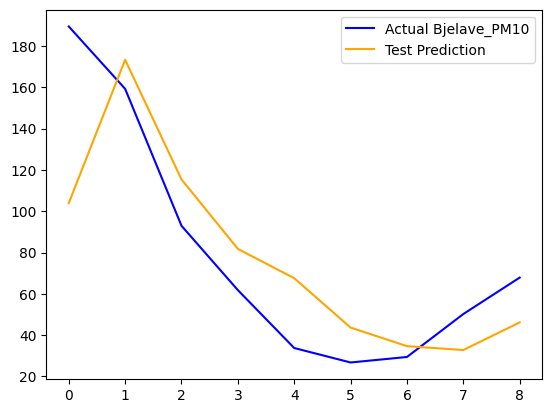

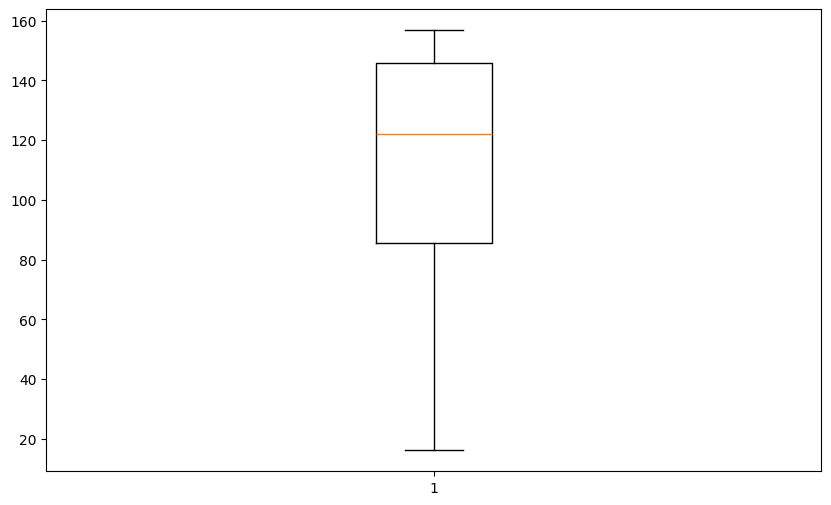

In [ ]:
plt.plot(y_test_PM10_daily_ws_week_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_week, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_week, y_test_PM10_daily_ws_week_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_week[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_week)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_week.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_week_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_week_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_week_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)

RMSE: 63.35356062375965
MAE: 43.26995881729656
R2 Score: -0.32058398988986125


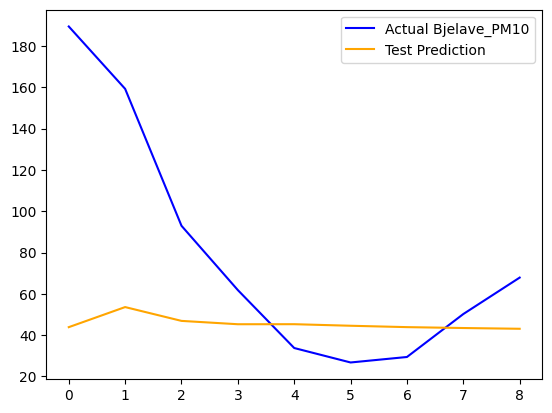

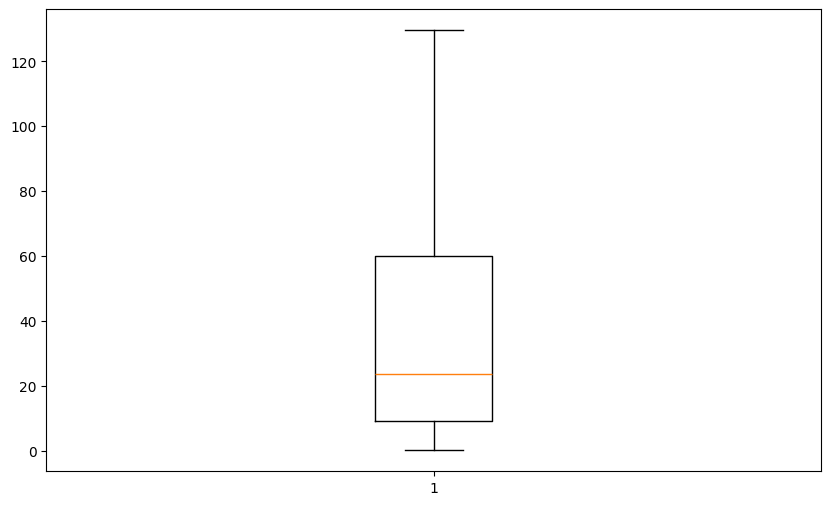

In [ ]:
plt.plot(y_test_PM10_daily_ws_week_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_week, walk_forward_predictions_unscaled[0])

**15-Day Prediction Window**

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


361/361 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0075 - mean_absolute_error: 0.0468 - root_mean_squared_error: 0.0852
Epoch 2/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0052 - mean_absolute_error: 0.0398 - root_mean_squared_error: 0.0717
Epoch 3/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0066 - mean_absolute_error: 0.0453 - root_mean_squared_error: 0.0812
Epoch 4/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0046 - mean_absolute_error: 0.0367 - root_mean_squared_error: 0.0674
Epoch 5/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0035 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0589
Epoch 6/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0586
Epoch 7/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0033 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0568
Epoch 8/15
361/361 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0043 - mean_absolute_er

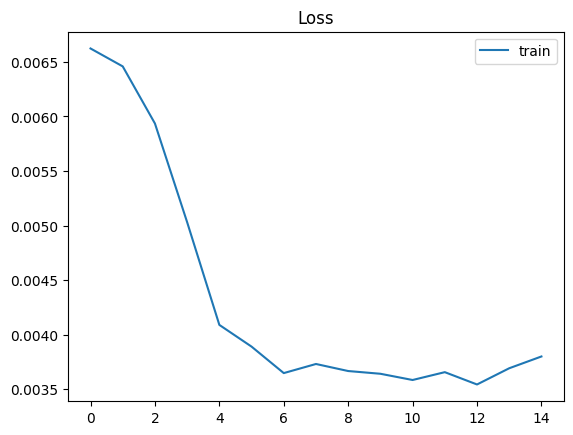

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_fifteen, y_train_PM10_daily_ws_fifteen)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_69 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_fifteen_scaled = model.predict(x_test_PM10_daily_ws_fifteen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


In [ ]:
testPredict_PM10_daily_ws_fifteen = scaler_PM10_daily_ws_fifteen.inverse_transform(testPredict_PM10_daily_ws_fifteen_scaled)

In [ ]:
y_test_PM10_daily_ws_fifteen_unscaled = scaler_PM10_daily_ws_fifteen.inverse_transform(y_test_PM10_daily_ws_fifteen.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_fifteen_unscaled, testPredict_PM10_daily_ws_fifteen))
mae = mean_absolute_error(y_test_PM10_daily_ws_fifteen_unscaled, testPredict_PM10_daily_ws_fifteen)
r2 = r2_score(y_test_PM10_daily_ws_fifteen_unscaled, testPredict_PM10_daily_ws_fifteen)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 43.76655514009207
MAE: 33.974882917699404
R2 Score: 0.33273123311098396


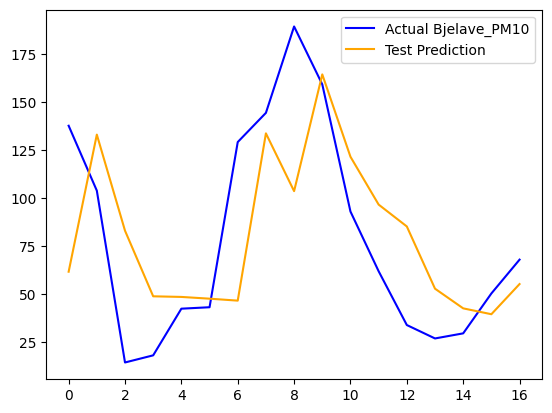

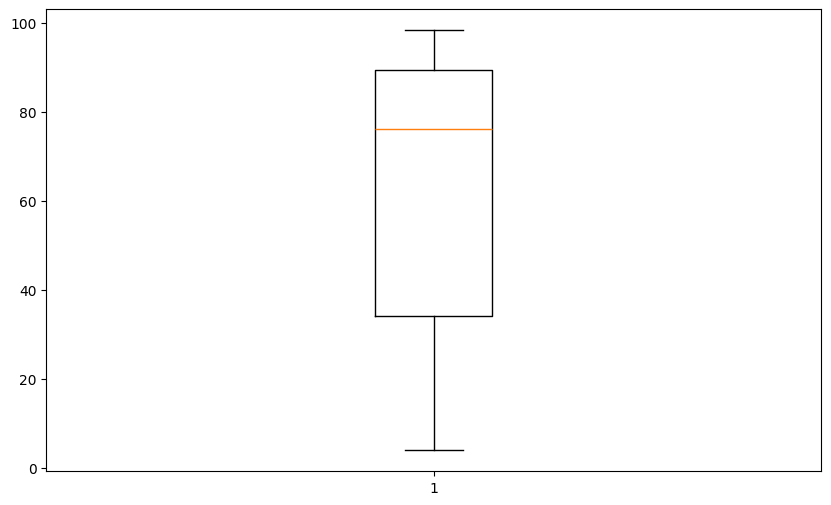

In [ ]:
plt.plot(y_test_PM10_daily_ws_fifteen_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_fifteen, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_fifteen, y_test_PM10_daily_ws_fifteen_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_fifteen[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_fifteen)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_fifteen.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_fifteen_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_fifteen_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_fifteen_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)

RMSE: 56.91288560763758
MAE: 50.39050052391853
R2 Score: -0.12833297254432963


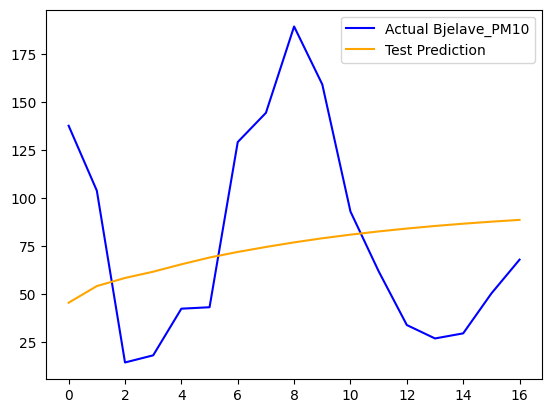

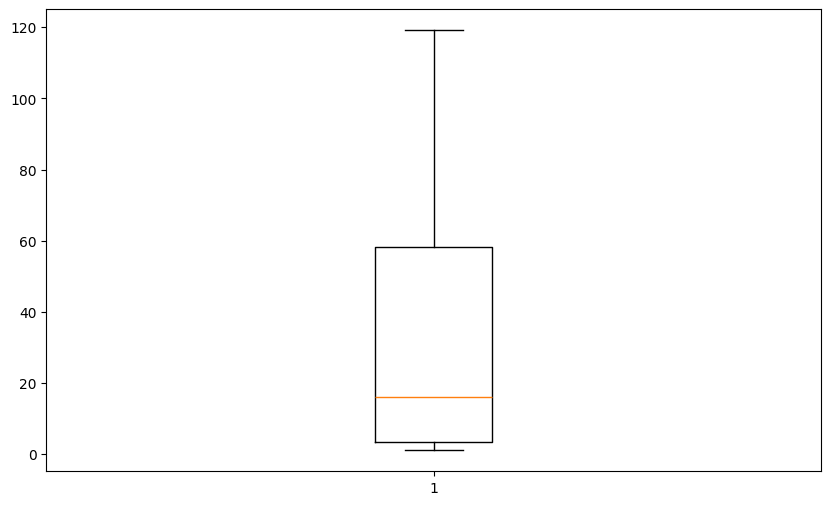

In [ ]:
plt.plot(y_test_PM10_daily_ws_fifteen_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_fifteen, walk_forward_predictions_unscaled[0])

**30 Day Prediction Window**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.0077 - mean_absolute_error: 0.0491 - root_mean_squared_error: 0.0877
Epoch 2/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0053 - mean_absolute_error: 0.0404 - root_mean_squared_error: 0.0719
Epoch 3/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0065 - mean_absolute_error: 0.0431 - root_mean_squared_error: 0.0803
Epoch 4/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0055 - mean_absolute_error: 0.0390 - root_mean_squared_error: 0.0739
Epoch 5/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0051 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0705
Epoch 6/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0043 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0652
Epoch 7/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0044 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0659
Epoch 8/15
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0040 - mean_

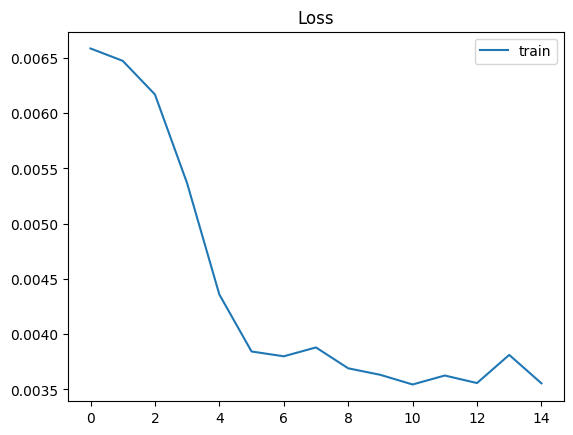

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_thirty, y_train_PM10_daily_ws_thirty)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_70 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_thirty_scaled = model.predict(x_test_PM10_daily_ws_thirty)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step


In [ ]:
testPredict_PM10_daily_ws_thirty = scaler_PM10_daily_ws_thirty.inverse_transform(testPredict_PM10_daily_ws_thirty_scaled)

In [ ]:
y_test_PM10_daily_ws_thirty_unscaled = scaler_PM10_daily_ws_thirty.inverse_transform(y_test_PM10_daily_ws_thirty.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_thirty_unscaled, testPredict_PM10_daily_ws_thirty))
mae = mean_absolute_error(y_test_PM10_daily_ws_thirty_unscaled, testPredict_PM10_daily_ws_thirty)
r2 = r2_score(y_test_PM10_daily_ws_thirty_unscaled, testPredict_PM10_daily_ws_thirty)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)
# previous results:
# RMSE: 36.51894921522029
# MAE: 26.330601179172024
# R2 Score: 0.3554883214703234

RMSE: 35.292092065513145
MAE: 25.777600725201644
R2 Score: 0.381780828229046


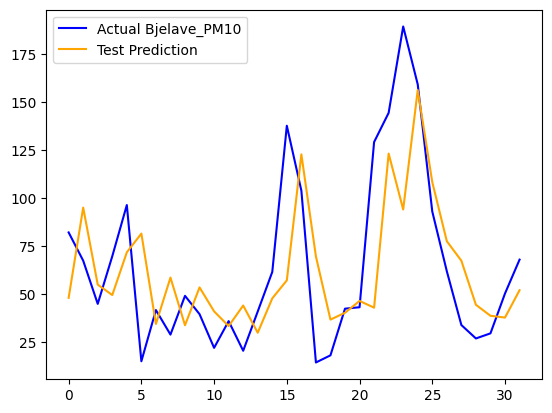

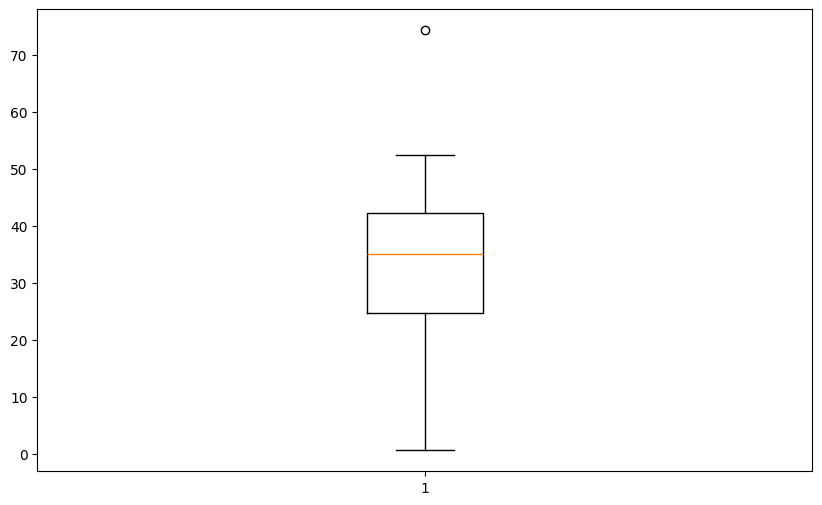

In [ ]:
plt.plot(y_test_PM10_daily_ws_thirty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_thirty, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_thirty, y_test_PM10_daily_ws_thirty_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_thirty[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_thirty)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_thirty.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_thirty_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_thirty_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_thirty_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)
# previous results:
# RMSE: 50.21773309961082
# MAE: 32.88232332502168
# R2 Score: -0.21873267183859202

RMSE: 47.319057913391525
MAE: 34.910178345648326
R2 Score: -0.11137299850684368


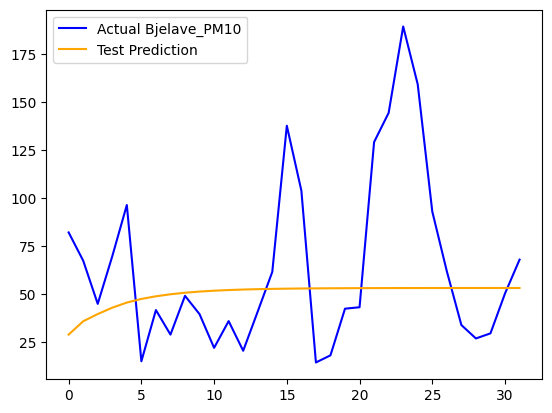

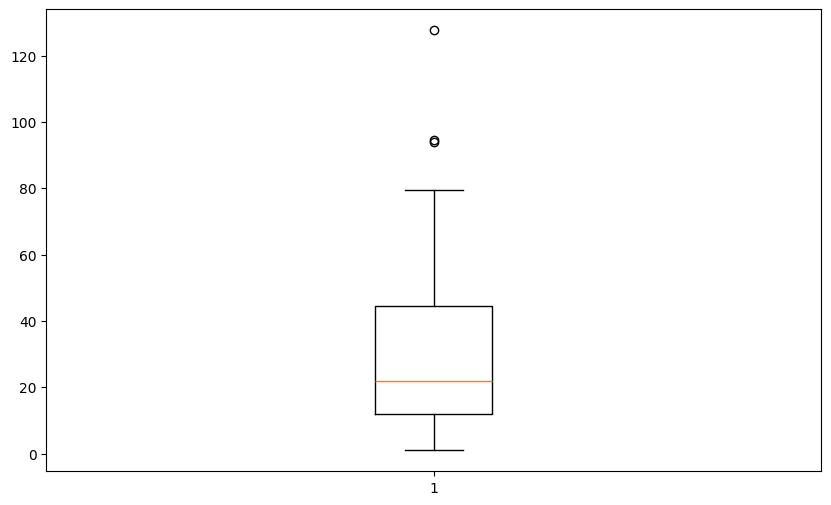

In [ ]:
plt.plot(y_test_PM10_daily_ws_thirty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_thirty, walk_forward_predictions_unscaled[0])

**60-Day Prediction Window**

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


352/352 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0061 - mean_absolute_error: 0.0433 - root_mean_squared_error: 0.0774
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0070 - mean_absolute_error: 0.0458 - root_mean_squared_error: 0.0831
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0077 - mean_absolute_error: 0.0470 - root_mean_squared_error: 0.0865
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0051 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0704
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0052 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0722
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0043 - mean_absolute_error: 0.0351 - root_mean_squared_error: 0.0655
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0590
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0042 - mean_absolute_e

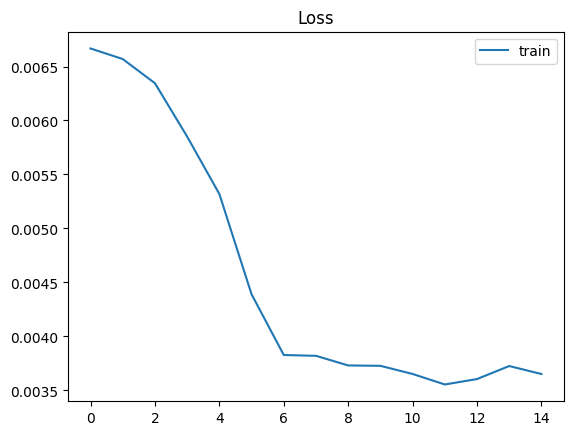

In [ ]:
model = build_model(look_back, num_features, params)
history = train_model(model, x_train_PM10_daily_ws_sixty, y_train_PM10_daily_ws_sixty)
plot_loss(history)

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_77 (LSTM)                  │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ (None, 3, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 45)             │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 605,588 (2.31 MB)

 Trainable params: 201,862 (788.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,726 (1.54 MB)

In [ ]:
testPredict_PM10_daily_ws_sixty_scaled = model.predict(x_test_PM10_daily_ws_sixty)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [ ]:
testPredict_PM10_daily_ws_sixty = scaler_PM10_daily_ws_sixty.inverse_transform(testPredict_PM10_daily_ws_sixty_scaled)

In [ ]:
y_test_PM10_daily_ws_sixty_unscaled = scaler_PM10_daily_ws_sixty.inverse_transform(y_test_PM10_daily_ws_sixty.reshape(-1, 1))

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_sixty_unscaled, testPredict_PM10_daily_ws_sixty))
mae = mean_absolute_error(y_test_PM10_daily_ws_sixty_unscaled, testPredict_PM10_daily_ws_sixty)
r2 = r2_score(y_test_PM10_daily_ws_sixty_unscaled, testPredict_PM10_daily_ws_sixty)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 31.869953194363607
MAE: 23.31689229557772
R2 Score: 0.33228044171357674


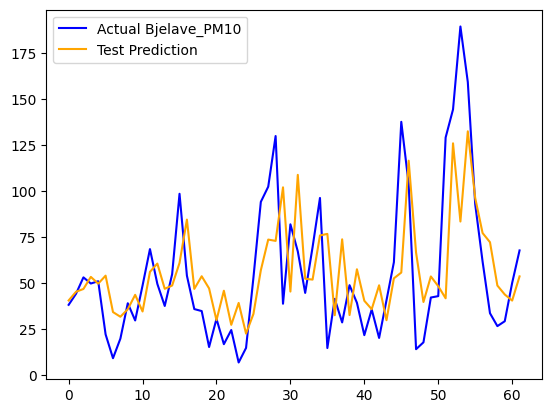

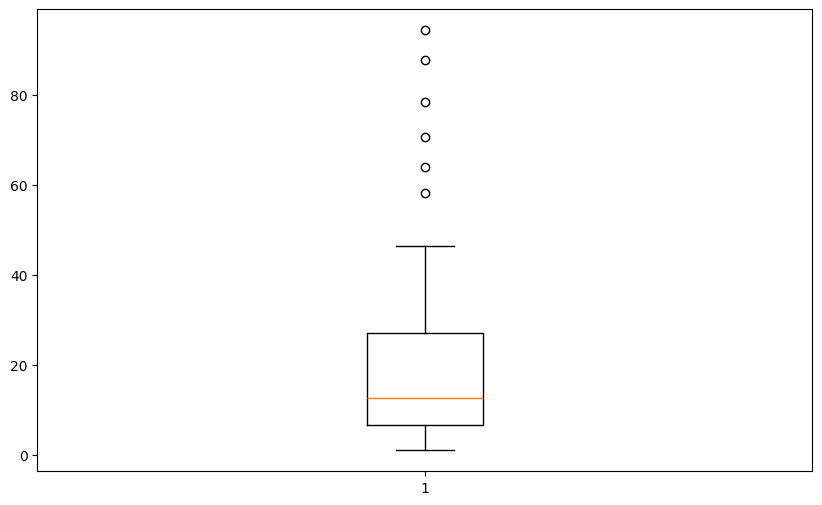

In [ ]:
plt.plot(y_test_PM10_daily_ws_sixty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(testPredict_PM10_daily_ws_sixty, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_sixty, y_test_PM10_daily_ws_sixty_unscaled[0])

In [ ]:
last_sequence = x_train_PM10_daily_ws_sixty[-1:]

In [ ]:
walk_forward_predictions_scaled = []

In [ ]:
for _ in range(len(y_test_PM10_daily_ws_sixty)):
    next_pred_scaled = model.predict(last_sequence, verbose=0)
    walk_forward_predictions_scaled.append(next_pred_scaled[0, 0])
    new_sequence_step = next_pred_scaled.reshape(1, 1, num_features)
    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step, axis=1)

In [ ]:
walk_forward_predictions_unscaled = scaler_PM10_daily_ws_sixty.inverse_transform(np.array(walk_forward_predictions_scaled).reshape(-1, 1))

In [ ]:
rmse_wf = np.sqrt(mean_squared_error(y_test_PM10_daily_ws_sixty_unscaled, walk_forward_predictions_unscaled))
mae_wf = mean_absolute_error(y_test_PM10_daily_ws_sixty_unscaled, walk_forward_predictions_unscaled)
r2_wf = r2_score(y_test_PM10_daily_ws_sixty_unscaled, walk_forward_predictions_unscaled)

print("RMSE:", rmse_wf)
print("MAE:", mae_wf)
print("R2 Score:", r2_wf)

RMSE: 38.99687280741869
MAE: 29.749649069464862
R2 Score: 0.00025138750944209143


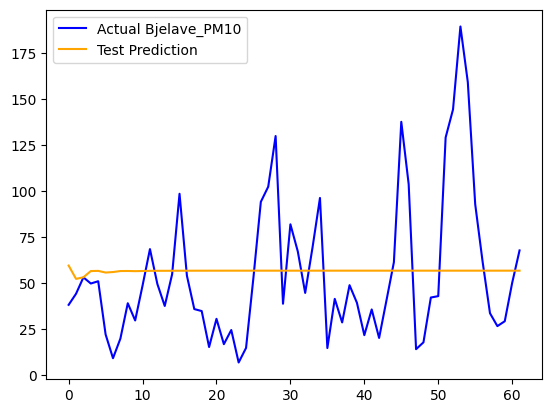

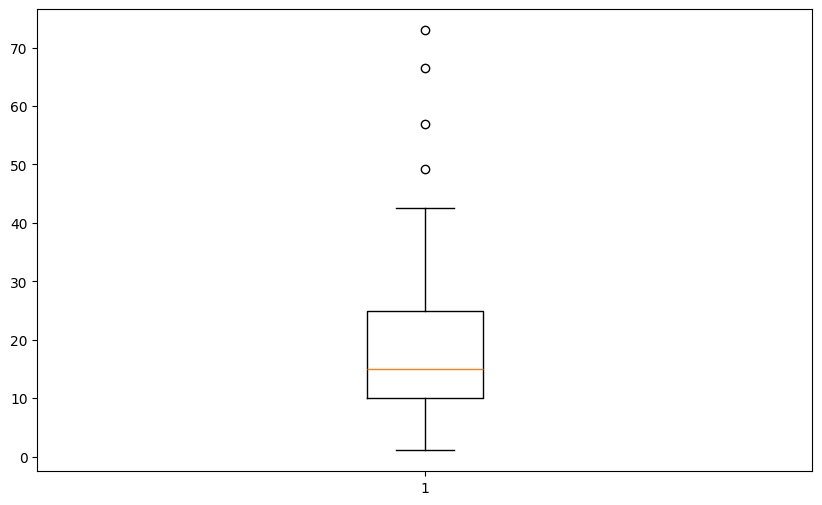

In [ ]:
plt.plot(y_test_PM10_daily_ws_sixty_unscaled, label='Actual Bjelave_PM10', color='blue')
plt.plot(walk_forward_predictions_unscaled, label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(testPredict_PM10_daily_ws_sixty, walk_forward_predictions_unscaled[0])

# LSTM for Direct Multi-step Time Series Prediction

In [ ]:
# R2>0 za horizon >= 15 danaaa

In [40]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    # plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_training_dataset(data, target_column_index, look_back=3, horizon=7):
    X, Y = [], []
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[(i + look_back):(i + look_back + horizon), target_column_index])
    return np.array(X), np.array(Y)

def train_multivariate_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    # x_val = x_train[-50:]
    # y_val = y_train[-50:]
    # x_train = x_train[:-50]
    # y_train = y_train[:-50]
    # history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stop])
    history = model.fit(x_train, y_train, epochs=18, batch_size=10, verbose=1, callbacks=[early_stop])
    return history

def denormalize_prediction(prediction, scaler, target_column_index, num_features):
    full_data = np.zeros((len(prediction), num_features))
    full_data[:, target_column_index] = prediction
    denormalized = scaler.inverse_transform(full_data)
    return denormalized[:, target_column_index]

def evaluate_forecasts(actual_data, predicted_data):
  rmse = np.sqrt(mean_squared_error(actual_data, predicted_data))
  mae = mean_absolute_error(actual_data, predicted_data)
  r2 = r2_score(actual_data, predicted_data)
  print("RMSE:", rmse)
  print("MAE:", mae)
  print("R2 Score:", r2)
  return rmse, mae, r2

In [41]:

def build_multivariate_multistep_model(look_back, num_features, params):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	# model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(Dropout(rate=params["dropout"]))
	#model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	#model.add(LSTM(units=params["lstm_units2"], return_sequences=True))
	model.add(LSTM(units=params["lstm_units1"], return_sequences=False))
	model.add(Dense(params["horizon"]))
	model.compile(loss=params["loss"], optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [42]:
params_mv = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
  "dropout": 0.2,
	"lstm_units": 100,
	"lstm_units3": 95,
	"lstm_units2": 90,
	"lstm_units1": 85,
	"lstm_units0": 35,
  "horizon": 7
}

In [ ]:
#train_data_combined_ws_week = train_data_combined_ws_week.set_index('DateTime')
#test_data_combined_ws_week = test_data_combined_ws_week.set_index('DateTime')

#scaler_data_combined_ws_week = MinMaxScaler(feature_range=(0,1))
#train_data_combined_ws_week_scaled = scaler_data_combined_ws_week.fit_transform(train_data_combined_ws_week)
#test_data_combined_ws_week_scaled = scaler_data_combined_ws_week.transform(test_data_combined_ws_week)

In [ ]:
test_data_combined_ws_week_scaled.shape

(26, 11)

In [43]:
params_mv['horizon'] = 7
horizon = params_mv['horizon']
#look_back=horizon + int(params_mv['horizon']/3 + 1)
look_back=horizon
num_features = train_data_combined_ws_week_scaled.shape[1]
X_train_ws_week, Y_train_ws_week = create_training_dataset(
    train_data_combined_ws_week_scaled,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train_ws_week shape: {X_train_ws_week.shape}")
print(f"Y_train_ws_week shape: {Y_train_ws_week.shape}")

X_train_ws_week shape: (1787, 7, 11)
Y_train_ws_week shape: (1787, 7)


**7-Day Prediction Window**

In [ ]:
model_week_multivariate = build_multivariate_multistep_model(look_back, num_features, params=params_mv)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_week_multivariate.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_217 (LSTM)                 │ (None, 7, 100)         │        44,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_218 (LSTM)                 │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_219 (LSTM)                 │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_220 (LSTM)                 │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_221 (LSTM)                 │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_222 (LSTM)                 │ (None, 7, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_223 (LSTM)                 │ (None, 85)             │        63,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 7)              │           602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,642 (1.95 MB)

 Trainable params: 510,642 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0071 - mean_absolute_error: 0.0473 - root_mean_squared_error: 0.0839
Epoch 2/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0054 - mean_absolute_error: 0.0399 - root_mean_squared_error: 0.0734
Epoch 3/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0054 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0733
Epoch 4/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0052 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0716
Epoch 5/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0062 - mean_absolute_error: 0.0420 - root_mean_squared_error: 0.0788
Epoch 6/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0396 - root_mean_squared_error: 0.0746
Epoch 7/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0058 - mean_absolute_error: 0.0401 - root_mean_squared_error: 0.0759
Epoch 8/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0052 - mean_a

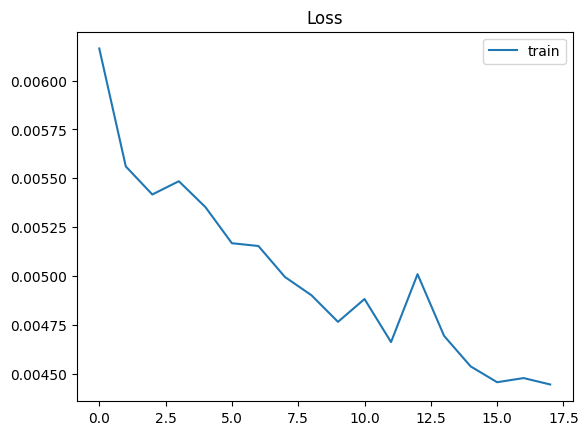

In [ ]:
history_week_multivariate = train_multivariate_model(model_week_multivariate, X_train_ws_week, Y_train_ws_week)
plot_loss(history_week_multivariate)

In [ ]:
last_sequence = train_data_combined_ws_week_scaled[-look_back:].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence.shape}")

Last sequence shape: (1, 7, 11)


In [ ]:
prediction_ws_week = model_week_multivariate.predict(last_sequence, verbose=0)
print(f"Raw prediction shape: {prediction_ws_week.shape}")  # (1, 7)
print(f"Raw prediction values: {prediction_ws_week}")

Raw prediction shape: (1, 7)
Raw prediction values: [[0.09814122 0.10117704 0.10987373 0.10988496 0.10501148 0.09800591
  0.10227656]]


In [ ]:
prediction_denormalized_ws_week = denormalize_prediction(
    prediction_ws_week.flatten(),
    scaler_data_combined_ws_week,
    index_of_target_feature,
    num_features
)

In [ ]:
print(f"Denormalized prediction for next 7 days: {prediction_denormalized_ws_week}")


Denormalized prediction for next 7 days: [49.70974194 51.17916067 55.3886021  55.39404038 53.03513756 49.64424451
 51.71135884]


In [ ]:
last_date = train_data_combined_ws_week.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')


In [ ]:
prediction_denormalized_ws_week

array([49.70974194, 51.17916067, 55.3886021 , 55.39404038, 53.03513756,
       49.64424451, 51.71135884])

In [ ]:
prediction_df_ws_week = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_week
})
print("\nPrediction results:")
print(prediction_df_ws_week)


Prediction results:
    DateTime  Bjelave_PM10
0 2022-12-06     49.709742
1 2022-12-07     51.179161
2 2022-12-08     55.388602
3 2022-12-09     55.394040
4 2022-12-10     53.035138
5 2022-12-11     49.644245
6 2022-12-12     51.711359


In [ ]:
df_test_data_combined_ws_week = test_data_combined_ws_week['Bjelave_PM10'][:7].reset_index()
df_test_data_combined_ws_week

,DateTime,Bjelave_PM10
0,2022-12-06,28.723416
1,2022-12-07,48.954487
2,2022-12-08,39.391658
3,2022-12-09,21.807971
4,2022-12-10,35.767727
5,2022-12-11,20.287982
6,2022-12-12,40.775529


In [ ]:
prediction_df_ws_week

,DateTime,Bjelave_PM10
0,2022-12-06,49.709742
1,2022-12-07,51.179161
2,2022-12-08,55.388602
3,2022-12-09,55.394040
4,2022-12-10,53.035138
5,2022-12-11,49.644245
6,2022-12-12,51.711359


In [ ]:
(rmse_ws_week, mae_ws_week, r2_ws_week) = evaluate_forecasts(df_test_data_combined_ws_week['Bjelave_PM10'], prediction_df_ws_week['Bjelave_PM10'])


RMSE: 21.074179449811325
MAE: 18.621930656128665
R2 Score: -3.6714691113690705


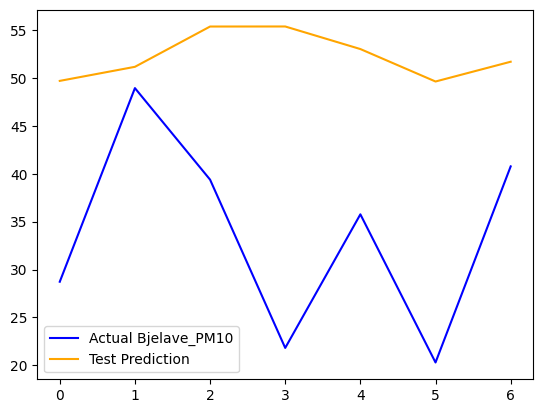

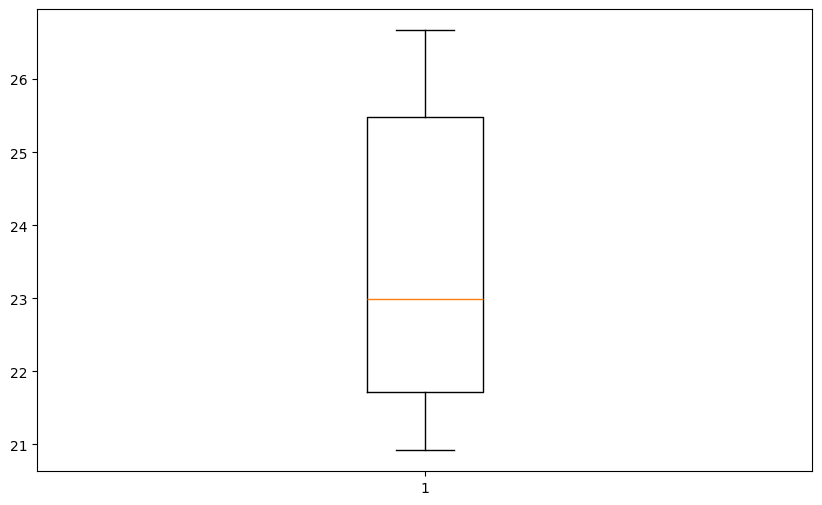

In [ ]:
plt.plot(df_test_data_combined_ws_week['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_df_ws_week['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_df_ws_week['Bjelave_PM10'], df_test_data_combined_ws_week['Bjelave_PM10'][0])

**7-Day Prediction Window (with time features)**

In [ ]:
params_mv['horizon'] = 7
horizon = params_mv['horizon']
#look_back=horizon + int(params_mv['horizon']/3 + 1)
look_back=horizon + int(params_mv['horizon']/5 + 1)
num_features = train_data_combined_ws_week_scaled_dt.shape[1]
X_train_ws_week_dt, Y_train_ws_week_dt = create_training_dataset(
    train_data_combined_ws_week_scaled_dt,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train_ws_week_dt shape: {X_train_ws_week_dt.shape}")
print(f"Y_train_ws_week_dt shape: {Y_train_ws_week_dt.shape}")

X_train_ws_week_dt shape: (1785, 9, 14)
Y_train_ws_week_dt shape: (1785, 7)


In [ ]:
params_mv['horizon']=7

In [ ]:
model_week_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_week_multivariate_dt.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_301 (LSTM)                 │ (None, 9, 100)         │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_302 (LSTM)                 │ (None, 9, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_303 (LSTM)                 │ (None, 9, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_304 (LSTM)                 │ (None, 9, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_305 (LSTM)                 │ (None, 9, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_306 (LSTM)                 │ (None, 9, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_307 (LSTM)                 │ (None, 85)             │        63,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 7)              │           602 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511,842 (1.95 MB)

 Trainable params: 511,842 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0075 - mean_absolute_error: 0.0478 - root_mean_squared_error: 0.0862
Epoch 2/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0062 - mean_absolute_error: 0.0419 - root_mean_squared_error: 0.0784
Epoch 3/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0058 - mean_absolute_error: 0.0424 - root_mean_squared_error: 0.0763
Epoch 4/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0049 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0701
Epoch 5/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0049 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0702
Epoch 6/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0046 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0675
Epoch 7/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0053 - mean_absolute_error: 0.0398 - root_mean_squared_error: 0.0724
Epoch 8/18
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0044 - mean_a

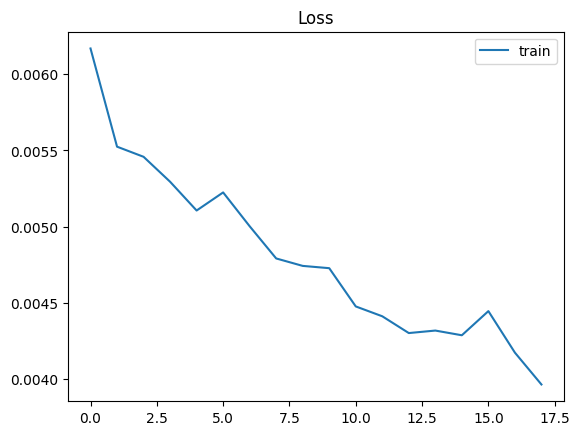

In [ ]:
history_week_multivariate_dt = train_multivariate_model(model_week_multivariate_dt, X_train_ws_week_dt, Y_train_ws_week_dt)
plot_loss(history_week_multivariate_dt)

In [ ]:
last_sequence_dt = train_data_combined_ws_week_scaled_dt[-look_back:].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence.shape}")

Last sequence shape: (1, 7, 11)


In [ ]:
prediction_ws_week_dt = model_week_multivariate_dt.predict(last_sequence_dt, verbose=0)
print(f"Raw prediction shape: {prediction_ws_week_dt.shape}")  # (1, 7)
print(f"Raw prediction values: {prediction_ws_week_dt}")

Raw prediction shape: (1, 7)
Raw prediction values: [[0.06971497 0.06554998 0.06593198 0.07242844 0.07322362 0.07644814
  0.08189239]]


In [ ]:
prediction_denormalized_ws_week_dt = denormalize_prediction(
    prediction_ws_week_dt.flatten(),
    scaler_data_combined_ws_week_dt,
    index_of_target_feature,
    num_features
)
print(f"Denormalized prediction for next 7 days: {prediction_denormalized_ws_week_dt}")

Denormalized prediction for next 7 days: [35.95064033 33.9346704  34.11956486 37.26403654 37.648925   39.20968022
 41.84485367]


In [ ]:
last_date = train_data_combined_ws_week.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')

In [ ]:
prediction_dates.shape

(7,)

In [ ]:
prediction_denormalized_ws_week_dt.shape

(7,)

In [ ]:
last_date = train_data_combined_ws_week_dt.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
prediction_ws_week_dt = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_week_dt
})
print("\nPrediction results:")
print(prediction_ws_week_dt)
print("\nActual results:")
df_test_data_combined_ws_week_dt = test_data_combined_ws_week_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_week_dt)


Prediction results:
    DateTime  Bjelave_PM10
0 2022-12-06     35.950640
1 2022-12-07     33.934670
2 2022-12-08     34.119565
3 2022-12-09     37.264037
4 2022-12-10     37.648925
5 2022-12-11     39.209680
6 2022-12-12     41.844854

Actual results:
    DateTime  Bjelave_PM10
0 2022-12-06     28.723416
1 2022-12-07     48.954487
2 2022-12-08     39.391658
3 2022-12-09     21.807971
4 2022-12-10     35.767727
5 2022-12-11     20.287982
6 2022-12-12     40.775529


In [ ]:
(rmse_ws_week_dt, mae_ws_week_dt, r2_ws_week_dt) = evaluate_forecasts(df_test_data_combined_ws_week_dt['Bjelave_PM10'], prediction_ws_week_dt['Bjelave_PM10'])

RMSE: 11.38436025721496
MAE: 9.263917115022199
R2 Score: -0.3632308164224769


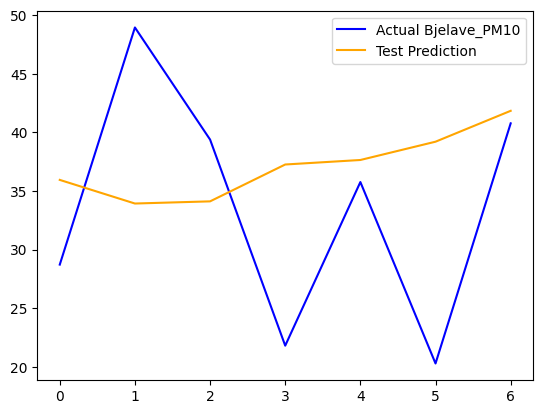

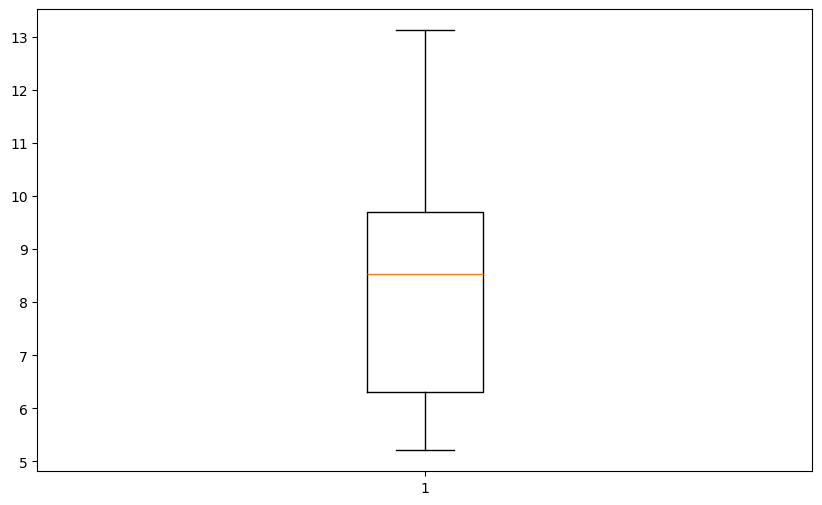

In [ ]:
plt.plot(df_test_data_combined_ws_week_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_week_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_ws_week_dt['Bjelave_PM10'], df_test_data_combined_ws_week_dt['Bjelave_PM10'][0])

**15-Day Prediction Window (with time features)**

In [ ]:
params_mv['horizon'] =15
horizon = params_mv['horizon']
#look_back=horizon + int(params_mv['horizon']/3 + 1)
look_back=horizon + int(params_mv['horizon']/5 + 1)
num_features = train_data_combined_ws_fifteen_scaled_dt.shape[1]
X_train_ws_fifteen_dt, Y_train_ws_fifteen_dt = create_training_dataset(
    train_data_combined_ws_fifteen_scaled_dt,
    index_of_target_feature,
    look_back=look_back,
    horizon=horizon
)
print(f"X_train_ws_fifteen_dt shape: {X_train_ws_fifteen_dt.shape}")
print(f"Y_train_ws_fifteen_dt shape: {Y_train_ws_fifteen_dt.shape}")

X_train_ws_fifteen_dt shape: (1747, 19, 14)
Y_train_ws_fifteen_dt shape: (1747, 15)


In [ ]:
params_mv['horizon'] = 15

In [ ]:
model_fifteen_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_fifteen_multivariate_dt.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_294 (LSTM)                 │ (None, 19, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_295 (LSTM)                 │ (None, 19, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_296 (LSTM)                 │ (None, 19, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_297 (LSTM)                 │ (None, 19, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_298 (LSTM)                 │ (None, 19, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_299 (LSTM)                 │ (None, 19, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_300 (LSTM)                 │ (None, 85)             │        63,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 15)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,530 (1.96 MB)

 Trainable params: 512,530 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0063 - mean_absolute_error: 0.0445 - root_mean_squared_error: 0.0794
Epoch 2/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0055 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0736
Epoch 3/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0054 - mean_absolute_error: 0.0390 - root_mean_squared_error: 0.0732
Epoch 4/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0050 - mean_absolute_error: 0.0378 - root_mean_squared_error: 0.0704
Epoch 5/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0051 - mean_absolute_error: 0.0383 - root_mean_squared_error: 0.0711
Epoch 6/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0047 - mean_absolute_error: 0.0379 - root_mean_squared_error: 0.0687
Epoch 7/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0049 - mean_absolute_error: 0.0378 - root_mean_squared_error: 0.0699
Epoch 8/18
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0046 - mean_

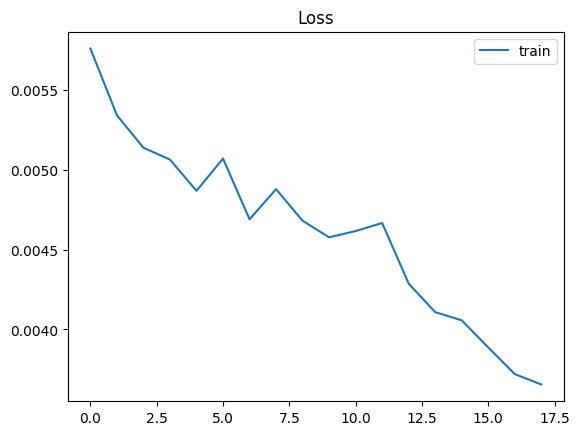

In [ ]:
history_fifteen_multivariate_dt = train_multivariate_model(model_fifteen_multivariate_dt, X_train_ws_fifteen_dt, Y_train_ws_fifteen_dt)
plot_loss(history_fifteen_multivariate_dt)

In [ ]:
last_sequence_dt = train_data_combined_ws_fifteen_scaled_dt[-look_back:].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence_dt.shape}")

Last sequence shape: (1, 19, 14)


In [ ]:
prediction_ws_fifteen_dt = model_fifteen_multivariate_dt.predict(last_sequence_dt, verbose=0)
print(f"Raw prediction shape: {prediction_ws_fifteen_dt.shape}")
print(f"Raw prediction values: {prediction_ws_fifteen_dt}")

Raw prediction shape: (1, 15)
Raw prediction values: [[0.03727599 0.04546093 0.0644542  0.08746966 0.09984492 0.12024401
  0.14069489 0.16742897 0.18324761 0.19445936 0.18839456 0.16628213
  0.14083456 0.12724799 0.09886967]]


In [ ]:
prediction_denormalized_ws_fifteen_dt = denormalize_prediction(
    prediction_ws_fifteen_dt.flatten(),
    scaler_data_combined_ws_fifteen_dt,
    index_of_target_feature,
    num_features
)
print(f"Denormalized prediction for next {params_mv['horizon']} days: {prediction_denormalized_ws_fifteen_dt}")

Denormalized prediction for next 15 days: [20.24926692 24.21100495 33.40427898 44.54440659 50.53437774 60.40810991
 70.3069058  83.24695055 90.90361527 96.33041743 93.39488334 82.69184883
 70.37450931 63.79823122 50.06232887]


In [ ]:
last_date = train_data_combined_ws_fifteen_dt.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
prediction_ws_fifteen_dt = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_fifteen_dt
})
print("\nPrediction results:")
print(prediction_ws_fifteen_dt)
print("\nActual results:")
df_test_data_combined_ws_fifteen_dt = test_data_combined_ws_fifteen_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_fifteen_dt)


Prediction results:
     DateTime  Bjelave_PM10
0  2022-11-16     20.249267
1  2022-11-17     24.211005
2  2022-11-18     33.404279
3  2022-11-19     44.544407
4  2022-11-20     50.534378
5  2022-11-21     60.408110
6  2022-11-22     70.306906
7  2022-11-23     83.246951
8  2022-11-24     90.903615
9  2022-11-25     96.330417
10 2022-11-26     93.394883
11 2022-11-27     82.691849
12 2022-11-28     70.374509
13 2022-11-29     63.798231
14 2022-11-30     50.062329

Actual results:
     DateTime  Bjelave_PM10
0  2022-11-16     35.974319
1  2022-11-17     34.893425
2  2022-11-18     15.358768
3  2022-11-19     30.674179
4  2022-11-20     16.908400
5  2022-11-21     24.596146
6  2022-11-22      6.960133
7  2022-11-23     14.861207
8  2022-11-24     53.118400
9  2022-11-25     94.224388
10 2022-11-26    102.462083
11 2022-11-27    129.990312
12 2022-11-28     38.872638
13 2022-11-29     82.039950
14 2022-11-30     67.309208


In [ ]:
(rmse_ws_fifteen_dt, mae_ws_fifteen_dt, r2_ws_fifteen_dt) = evaluate_forecasts(df_test_data_combined_ws_fifteen_dt['Bjelave_PM10'], prediction_ws_fifteen_dt['Bjelave_PM10'])

RMSE: 34.015821129083534
MAE: 28.18273639009225
R2 Score: 0.10498566377503904


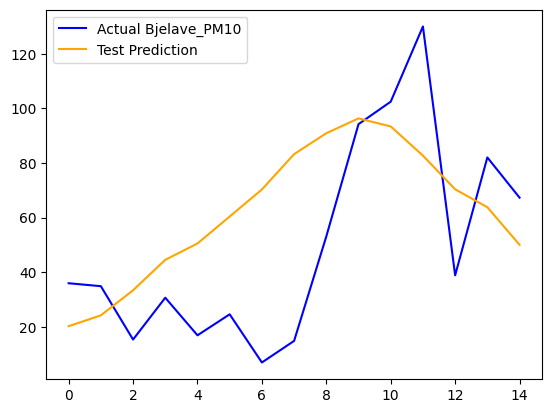

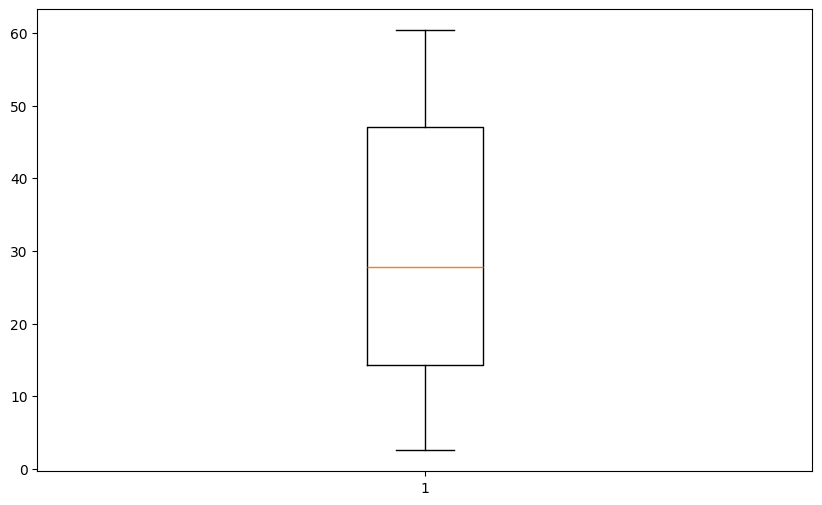

In [ ]:
plt.plot(df_test_data_combined_ws_fifteen_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_fifteen_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_ws_fifteen_dt['Bjelave_PM10'], df_test_data_combined_ws_fifteen_dt['Bjelave_PM10'][0])

**30-Day Prediction Window (with time features)**

In [44]:
params_mv['horizon'] = 30
horizon = params_mv['horizon']
#look_back=horizon
look_back=horizon + int(params_mv['horizon']/5 + 1)
num_features = train_data_combined_ws_thirty_scaled_dt.shape[1]
X_train_ws_thirty_dt, Y_train_ws_thirty_dt = create_training_dataset(
    train_data_combined_ws_thirty_scaled_dt,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train_ws_thirty_dt shape: {X_train_ws_thirty_dt.shape}")
print(f"Y_train_ws_thirty_dt shape: {Y_train_ws_thirty_dt.shape}")

X_train_ws_thirty_dt shape: (1699, 37, 14)
Y_train_ws_thirty_dt shape: (1699, 30)


In [45]:
model_thirty_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)
model_thirty_multivariate_dt.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 37, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 37, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 37, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 37, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 37, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 37, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 85)             │        63,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,820 (1.96 MB)

 Trainable params: 513,820 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0059 - mean_absolute_error: 0.0421 - root_mean_squared_error: 0.0762
Epoch 2/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0049 - mean_absolute_error: 0.0368 - root_mean_squared_error: 0.0697
Epoch 3/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0045 - mean_absolute_error: 0.0359 - root_mean_squared_error: 0.0669
Epoch 4/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0048 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.0690
Epoch 5/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0050 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0705
Epoch 6/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0049 - mean_absolute_error: 0.0376 - root_mean_squared_error: 0.0697
Epoch 7/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0048 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0691
Epoch 8/18
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0040 - mean_a

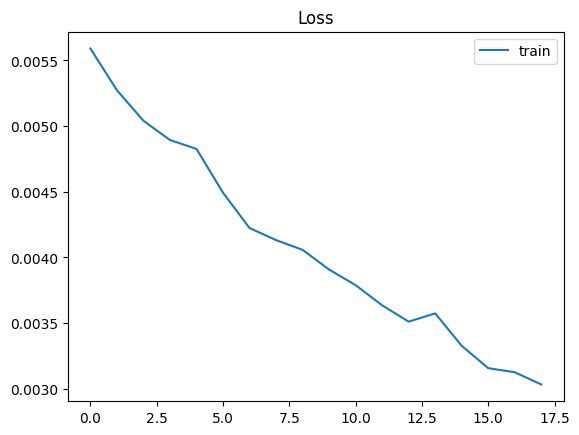

In [ ]:
history_thirty_multivariate_dt = train_multivariate_model(model_thirty_multivariate_dt, X_train_ws_thirty_dt, Y_train_ws_thirty_dt)
plot_loss(history_thirty_multivariate_dt)

In [ ]:
last_sequence_dt = train_data_combined_ws_thirty_scaled_dt[-look_back:].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence_dt.shape}")

Last sequence shape: (1, 37, 14)


In [ ]:
prediction_ws_thirty_dt = model_thirty_multivariate_dt.predict(last_sequence_dt, verbose=0)
print(f"Raw prediction shape: {prediction_ws_thirty_dt.shape}")
print(f"Raw prediction values: {prediction_ws_thirty_dt}")

Raw prediction shape: (1, 30)
Raw prediction values: [[0.05647883 0.04686956 0.04635066 0.04359824 0.03130297 0.0281914
  0.03847916 0.05905297 0.07482067 0.07447165 0.07912133 0.08459079
  0.07357622 0.06827082 0.07234409 0.07288154 0.06162535 0.06162945
  0.07528275 0.07683737 0.07132848 0.09537861 0.11604597 0.13008788
  0.13391902 0.12490901 0.13443804 0.10834102 0.10040817 0.08818154]]


In [ ]:
prediction_denormalized_ws_thirty_dt = denormalize_prediction(
    prediction_ws_thirty_dt.flatten(),
    scaler_data_combined_ws_thirty_dt,
    index_of_target_feature,
    num_features
)
print(f"Denormalized prediction for next {params_mv['horizon']} days: {prediction_denormalized_ws_thirty_dt}")

Denormalized prediction for next 30 days: [29.54397866 24.89282447 24.64165902 23.30941093 17.35815871 15.85207034
 20.83163579 30.78993366 38.42194037 38.25300735 40.50358084 43.15095436
 37.81959266 35.25163323 37.22320974 37.48334943 32.03503757 32.03702283
 38.64560245 39.39808    36.7316256  48.37255864 58.37613888 65.17281895
 67.02719466 62.66610154 67.278416   54.64673064 50.80700601 44.88897674]


In [ ]:
last_date = train_data_combined_ws_thirty_dt.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
prediction_ws_thirty_dt = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_thirty_dt
})
print("\nPrediction results:")
print(prediction_ws_thirty_dt)
print("\nActual results:")
df_test_data_combined_ws_thirty_dt = test_data_combined_ws_thirty_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_thirty_dt)


Prediction results:
     DateTime  Bjelave_PM10
0  2022-11-01     29.543979
1  2022-11-02     24.892824
2  2022-11-03     24.641659
3  2022-11-04     23.309411
4  2022-11-05     17.358159
5  2022-11-06     15.852070
6  2022-11-07     20.831636
7  2022-11-08     30.789934
8  2022-11-09     38.421940
9  2022-11-10     38.253007
10 2022-11-11     40.503581
11 2022-11-12     43.150954
12 2022-11-13     37.819593
13 2022-11-14     35.251633
14 2022-11-15     37.223210
15 2022-11-16     37.483349
16 2022-11-17     32.035038
17 2022-11-18     32.037023
18 2022-11-19     38.645602
19 2022-11-20     39.398080
20 2022-11-21     36.731626
21 2022-11-22     48.372559
22 2022-11-23     58.376139
23 2022-11-24     65.172819
24 2022-11-25     67.027195
25 2022-11-26     62.666102
26 2022-11-27     67.278416
27 2022-11-28     54.646731
28 2022-11-29     50.807006
29 2022-11-30     44.888977

Actual results:
     DateTime  Bjelave_PM10
0  2022-11-01     53.203658
1  2022-11-02     49.864446
2  2022-11

In [ ]:
(rmse_ws_thirty_dt, mae_ws_thirty_dt, r2_ws_thirty_dt) = evaluate_forecasts(df_test_data_combined_ws_thirty_dt['Bjelave_PM10'], prediction_ws_thirty_dt['Bjelave_PM10'])

RMSE: 26.316182879437452
MAE: 20.666901982981877
R2 Score: 0.20173712073593397


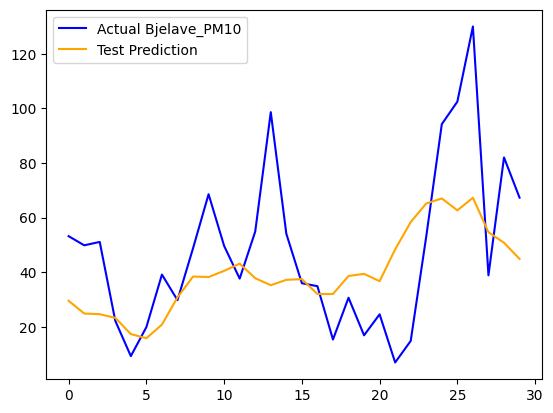

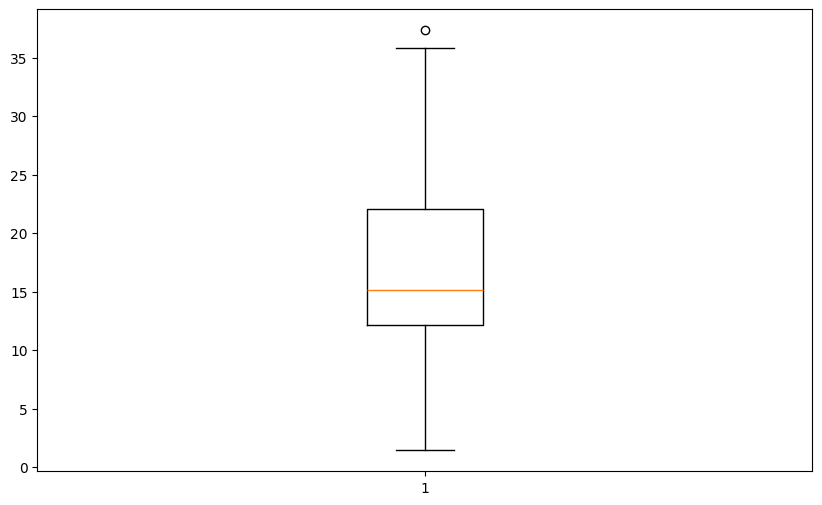

In [ ]:
plt.plot(df_test_data_combined_ws_thirty_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_ws_thirty_dt['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_ws_thirty_dt['Bjelave_PM10'], df_test_data_combined_ws_thirty_dt['Bjelave_PM10'][0])

**60-Day Prediction Window (with time features)**

In [ ]:
params_mv['horizon'] = 60
horizon = params_mv['horizon']
look_back=horizon + int(params_mv['horizon']/5 + 1)
#look_back=horizon
num_features = train_data_combined_ws_sixty_scaled_dt.shape[1]
X_train_dt, Y_train_dt = create_training_dataset(
    train_data_combined_ws_sixty_scaled_dt,
    index_of_target_feature,
    look_back=look_back,
    horizon=params_mv['horizon']
)
print(f"X_train shape: {X_train_dt.shape}")
print(f"Y_train shape: {Y_train_dt.shape}")

X_train shape: (1573, 73, 14)
Y_train shape: (1573, 60)


In [ ]:
look_back

73

In [ ]:
model_sixty_multivariate_dt = build_multivariate_multistep_model(look_back, num_features, params=params_mv)
model_sixty_multivariate_dt.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_287 (LSTM)                 │ (None, 73, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_288 (LSTM)                 │ (None, 73, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_289 (LSTM)                 │ (None, 73, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_290 (LSTM)                 │ (None, 73, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_291 (LSTM)                 │ (None, 73, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_292 (LSTM)                 │ (None, 73, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_293 (LSTM)                 │ (None, 85)             │        63,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 60)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516,400 (1.97 MB)

 Trainable params: 516,400 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0069 - mean_absolute_error: 0.0450 - root_mean_squared_error: 0.0821
Epoch 2/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0054 - mean_absolute_error: 0.0393 - root_mean_squared_error: 0.0737
Epoch 3/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0052 - mean_absolute_error: 0.0382 - root_mean_squared_error: 0.0720
Epoch 4/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0049 - mean_absolute_error: 0.0373 - root_mean_squared_error: 0.0700
Epoch 5/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0048 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0691
Epoch 6/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0054 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0734
Epoch 7/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0046 - mean_absolute_error: 0.0361 - root_mean_squared_error: 0.0681
Epoch 8/18
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0044 - mean_

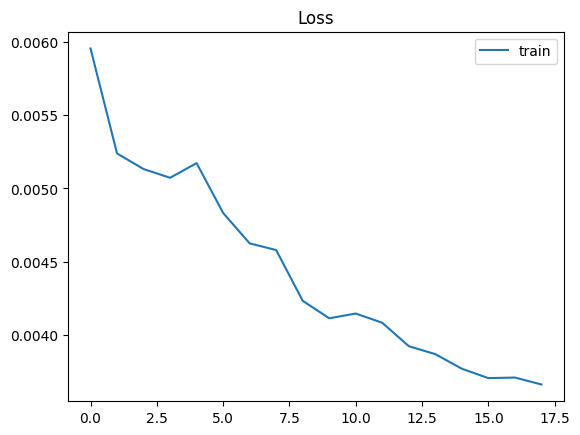

In [ ]:
history_sixty_multivariate_dt = train_multivariate_model(model_sixty_multivariate_dt, X_train_dt, Y_train_dt)
plot_loss(history_sixty_multivariate_dt)

In [ ]:
last_sequence_dt = train_data_combined_ws_sixty_scaled_dt[-look_back:].reshape(1, look_back, num_features)
print(f"Last sequence shape: {last_sequence_dt.shape}")

Last sequence shape: (1, 73, 14)


In [ ]:
prediction_ws_sixty_dt = model_sixty_multivariate_dt.predict(last_sequence_dt, verbose=0)
print(f"Raw prediction shape: {prediction_ws_sixty_dt.shape}")
print(f"Raw prediction values: {prediction_ws_sixty_dt}")

Raw prediction shape: (1, 60)
Raw prediction values: [[0.05331693 0.04717763 0.03988495 0.03586963 0.03387921 0.03438554
  0.0310692  0.03296379 0.0359092  0.03985565 0.03745812 0.04213206
  0.04650345 0.0459623  0.05035412 0.05378325 0.05210267 0.04715779
  0.04347845 0.03915312 0.0322351  0.03709365 0.03917235 0.04154808
  0.03082095 0.03561983 0.03346933 0.03527727 0.03188486 0.03421822
  0.03599858 0.03738241 0.03628092 0.03957442 0.0399436  0.03664026
  0.04165483 0.04390112 0.04032542 0.04108573 0.04554895 0.05164763
  0.04703596 0.04345408 0.04462124 0.04355089 0.04838039 0.04887567
  0.05801658 0.05880918 0.06333119 0.06250982 0.06451411 0.06563482
  0.06497609 0.0727183  0.07509939 0.07693478 0.07786001 0.07992898]]


In [ ]:
prediction_denormalized_ws_sixty_dt = denormalize_prediction(
    prediction_ws_sixty_dt.flatten(),
    scaler_data_combined_ws_sixty_dt,
    index_of_target_feature,
    num_features
)
print(f"Denormalized prediction for next {params_mv['horizon']} days: {prediction_denormalized_ws_sixty_dt}")

Denormalized prediction for next 60 days: [28.0135307  25.04193552 21.51207771 19.56854912 18.60513068 18.8502051
 17.24500597 18.16204031 19.58770032 21.49789417 20.33742267 22.59973823
 24.71561681 24.45368479 26.5794482  28.23924115 27.42579567 25.03233378
 23.25142901 21.15784812 17.80933438 20.16100659 21.16715776 22.31707907
 17.1248444  19.44763564 18.40673607 19.28182927 17.63980992 18.76922046
 19.63096498 20.30077375 19.76762351 21.36176937 21.54046462 19.94155305
 22.36874818 23.45601381 21.72527433 22.09328897 24.25360785 27.20554334
 24.97336373 23.23963464 23.80457071 23.28649116 25.62410785 25.86383414
 30.28829157 30.67193226 32.86071378 32.4631456  33.43327715 33.97573522
 33.65688874 37.40433563 38.55685166 39.44522863 39.89306848 40.89450623]


In [ ]:
prediction_denormalized_ws_sixty_dt.shape

(60,)

In [ ]:
last_date = train_data_combined_ws_sixty_dt.index[-1]
prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=params_mv['horizon'], freq='D')
prediction_ws_sixty_dt = pd.DataFrame({
    'DateTime': prediction_dates,
    'Bjelave_PM10': prediction_denormalized_ws_sixty_dt
})
print("\nPrediction results:")
print(prediction_ws_thirty_dt)
print("\nActual results:")
df_test_data_combined_ws_sixty_dt = test_data_combined_ws_sixty_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_sixty_dt)


Prediction results:
     DateTime  Bjelave_PM10
0  2022-11-01     29.543979
1  2022-11-02     24.892824
2  2022-11-03     24.641659
3  2022-11-04     23.309411
4  2022-11-05     17.358159
5  2022-11-06     15.852070
6  2022-11-07     20.831636
7  2022-11-08     30.789934
8  2022-11-09     38.421940
9  2022-11-10     38.253007
10 2022-11-11     40.503581
11 2022-11-12     43.150954
12 2022-11-13     37.819593
13 2022-11-14     35.251633
14 2022-11-15     37.223210
15 2022-11-16     37.483349
16 2022-11-17     32.035038
17 2022-11-18     32.037023
18 2022-11-19     38.645602
19 2022-11-20     39.398080
20 2022-11-21     36.731626
21 2022-11-22     48.372559
22 2022-11-23     58.376139
23 2022-11-24     65.172819
24 2022-11-25     67.027195
25 2022-11-26     62.666102
26 2022-11-27     67.278416
27 2022-11-28     54.646731
28 2022-11-29     50.807006
29 2022-11-30     44.888977

Actual results:
     DateTime  Bjelave_PM10
0  2022-09-02      9.213785
1  2022-09-03     20.201577
2  2022-09

In [ ]:
(rmse_ws_sixty_dt, mae_ws_sixty_dt, r2_ws_sixty_dt) = evaluate_forecasts(df_test_data_combined_ws_sixty_dt['Bjelave_PM10'], prediction_ws_sixty_dt['Bjelave_PM10'])

RMSE: 11.961889153079229
MAE: 9.526326950984705
R2 Score: 0.2611057693273542


**90-Day Prediction Window (with time features)**

# LSTM for Multivariate Multi-step Time Series Prediction

In [2]:
params_mv = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "lstm_units": 64,
    "lstm_units1": 60,
    "horizon": 7,
		"look_back": 15
}
num_features=train_data_combined_ws_week_dt.shape[1]


NameError: name 'train_data_combined_ws_week_dt' is not defined

In [ ]:
def build_multivariate_multistep_model(look_back, num_features, params):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units1"], return_sequences=False))

    model.add(Dense(params["horizon"] * num_features))
    model.add(Reshape((params["horizon"], num_features)))

    model.compile(
        loss=params["loss"],
        optimizer=params["optimizer"],
        metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
    )
    return model

In [ ]:
def create_full_multivariate_dataset(data, look_back=30, horizon=7):
    X, Y = [], []
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[(i + look_back):(i + look_back + horizon), :])
    return np.array(X), np.array(Y)

In [ ]:
def train_multivariate_model(model, x_train, y_train):

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history = model.fit(
        x_train, y_train,
        epochs=15,
        batch_size=5,
        verbose=1,
        callbacks=[early_stop]
    )
    return history

In [ ]:
def create_full_multivariate_dataset(data, look_back=30, horizon=7):
    X, Y = [], []
    for i in range(len(data) - look_back - horizon + 1):
        X.append(data[i:(i + look_back), :])
        Y.append(data[(i + look_back):(i + look_back + horizon), :])
    return np.array(X), np.array(Y)

def train_multivariate_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history = model.fit(
        x_train, y_train,
        epochs=25,
        batch_size=15,
        verbose=1,
        callbacks=[early_stop]
    )
    return history


In [ ]:
X_train_ws_week, Y_train_ws_week = create_full_multivariate_dataset(
    train_data_combined_ws_week_scaled_dt,
    look_back=params_mv["look_back"],
    horizon=params_mv["horizon"]
)
print(f"X_train_ws_week.shape: {X_train_ws_week.shape}")
print(f"Y_train_ws_week.shape: {Y_train_ws_week.shape}")
params_mv["target_col_idx"] = index_of_target_feature
params_mv["target_weight"] = 3.0

X_train_ws_week.shape: (1779, 15, 14)
Y_train_ws_week.shape: (1779, 7, 14)


In [ ]:
model_week_multivariate = build_multivariate_multistep_model(params_mv["look_back"], num_features, params=params_mv)
model_week_multivariate.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_161 (LSTM)                 │ (None, 15, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_162 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_163 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_164 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_165 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_166 (LSTM)                 │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_167 (LSTM)                 │ (None, 60)             │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 98)             │         5,978 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 7, 14)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,322 (864.54 KB)

 Trainable params: 221,322 (864.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1064 - mean_absolute_error: 0.2347 - root_mean_squared_error: 0.3183
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0441 - mean_absolute_error: 0.1510 - root_mean_squared_error: 0.2101
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0442 - mean_absolute_error: 0.1512 - root_mean_squared_error: 0.2102
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0365 - mean_absolute_error: 0.1374 - root_mean_squared_error: 0.1911
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0349 - mean_absolute_error: 0.1324 - root_mean_squared_error: 0.1867
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0313 - mean_absolute_error: 0.1242 - root_mean_squared_error: 0.1769
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0302 - mean_absolute_error: 0.1208 - root_mean_squared_error: 0.1738
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0262 - mean_a

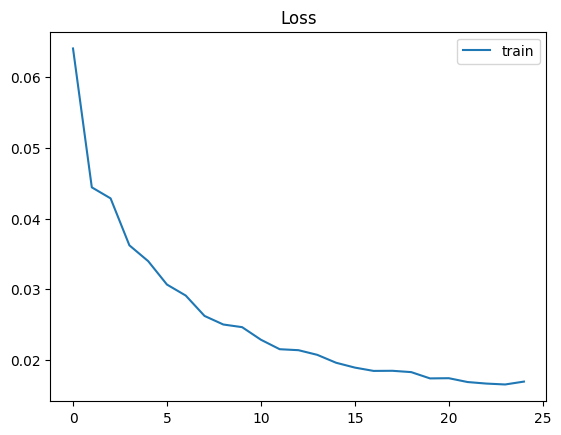

In [ ]:
history_week_multivariate = train_multivariate_model(
    model_week_multivariate,
    X_train_ws_week,
    Y_train_ws_week
)

plot_loss(history_week_multivariate)

In [ ]:
last_sequence = train_data_combined_ws_week_scaled_dt[-look_back:].reshape(1, look_back, num_features)
prediction_all_vars = model_week_multivariate.predict(last_sequence, verbose=0)

In [ ]:
target_predictions = prediction_all_vars[0, :, index_of_target_feature]

prediction_denormalized_ws_week = denormalize_prediction(
    target_predictions,
    scaler_data_combined_ws_week_dt,
    index_of_target_feature,
    num_features
)
prediction_df_ws_week = pd.DataFrame({
    'Bjelave_PM10': prediction_denormalized_ws_week
})
print("\nPrediction results:")
print(prediction_df_ws_week)

print("\nActual results:")
df_test_data_combined_ws_week_dt = test_data_combined_ws_week_dt['Bjelave_PM10'][:params_mv['horizon']].reset_index()
print(df_test_data_combined_ws_week_dt)


Prediction results:
   Bjelave_PM10
0     34.352286
1     38.309806
2     42.413692
3     56.629995
4     44.812148
5     68.064703
6     63.905331

Actual results:
    DateTime  Bjelave_PM10
0 2022-12-06     28.723416
1 2022-12-07     48.954487
2 2022-12-08     39.391658
3 2022-12-09     21.807971
4 2022-12-10     35.767727
5 2022-12-11     20.287982
6 2022-12-12     40.775529


RMSE: 24.68690726498166
MAE: 19.15265014216846
R2 Score: -5.410405542316653


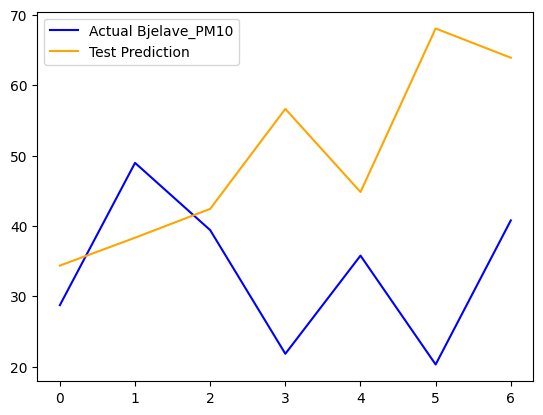

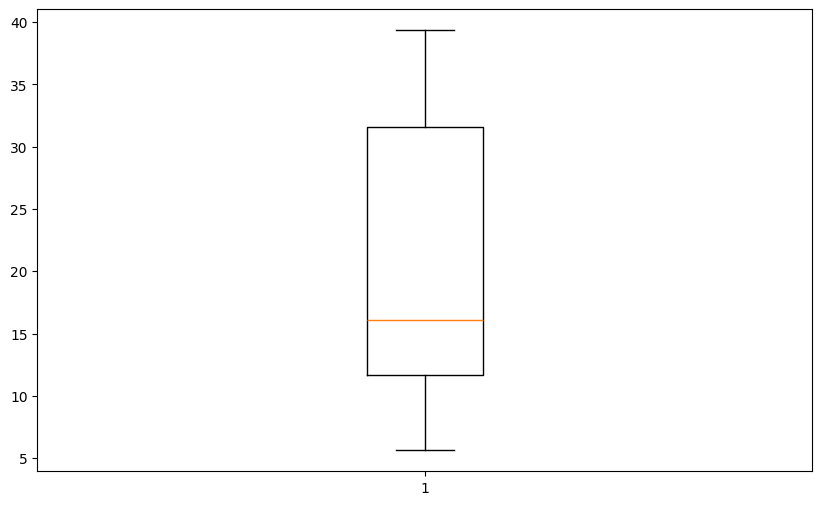

In [ ]:
(rmse_ws_week, mae_ws_week, r2_ws_week) = evaluate_forecasts(df_test_data_combined_ws_week_dt['Bjelave_PM10'], prediction_df_ws_week['Bjelave_PM10'])

plt.plot(df_test_data_combined_ws_week_dt['Bjelave_PM10'], label='Actual Bjelave_PM10', color='blue')
plt.plot(prediction_df_ws_week['Bjelave_PM10'], label='Test Prediction', color='orange')
plt.legend()
plt.show()

plot_boxplot(prediction_df_ws_week['Bjelave_PM10'], df_test_data_combined_ws_week_dt['Bjelave_PM10'][0])

# LSTM for Multivariate One-step Time Series Prediction [bad results]

In [ ]:
# za sada jako losa predikcija, nema smisla korisiti za duze periode

In [ ]:
num_features=train_data_combined_ws_week_scaled_dt.shape[1]

In [ ]:
def build_simple_model(look_back, num_features, params):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(look_back, num_features)))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(LSTM(units=params["lstm_units1"], return_sequences=False))

    model.add(Dense(num_features))

    model.compile(
        loss=params["loss"],
        optimizer=params["optimizer"],
        metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
    )
    return model

In [ ]:
def create_one_day_dataset(data, look_back=30):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, :])
    return np.array(X), np.array(Y)


In [ ]:
X_train, Y_train = create_one_day_dataset(
    train_data_combined_ws_week_scaled_dt,
    look_back=look_back
)
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")


X_train shape: (1770, 30, 14)
Y_train shape: (1770, 14)


In [ ]:
params_simple = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "lstm_units": 200,
    "lstm_units1": 170
}

In [ ]:
model = build_simple_model(look_back, num_features, params_simple)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_126 (LSTM)                 │ (None, 30, 200)        │       172,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_127 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_128 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_129 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_131 (LSTM)                 │ (None, 30, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_132 (LSTM)                 │ (None, 170)            │       252,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 14)             │         2,394 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,030,674 (7.75 MB)

 Trainable params: 2,030,674 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

def train_simple_model(model, x_train, y_train):
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

    history = model.fit(
        x_train, y_train,
        epochs=18,
        batch_size=10,
        verbose=1,
        callbacks=[early_stop]
    )
    return history


Epoch 1/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0600 - mean_absolute_error: 0.1710 - root_mean_squared_error: 0.2396
Epoch 2/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0296 - mean_absolute_error: 0.1184 - root_mean_squared_error: 0.1721
Epoch 3/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0278 - mean_absolute_error: 0.1144 - root_mean_squared_error: 0.1667
Epoch 4/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0266 - mean_absolute_error: 0.1099 - root_mean_squared_error: 0.1630
Epoch 5/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0245 - mean_absolute_error: 0.1069 - root_mean_squared_error: 0.1566
Epoch 6/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0228 - mean_absolute_error: 0.1012 - root_mean_squared_error: 0.1511
Epoch 7/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0223 - mean_absolute_error: 0.1001 - root_mean_squared_error: 0.1493
Epoch 8/18
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0210 - mean_a

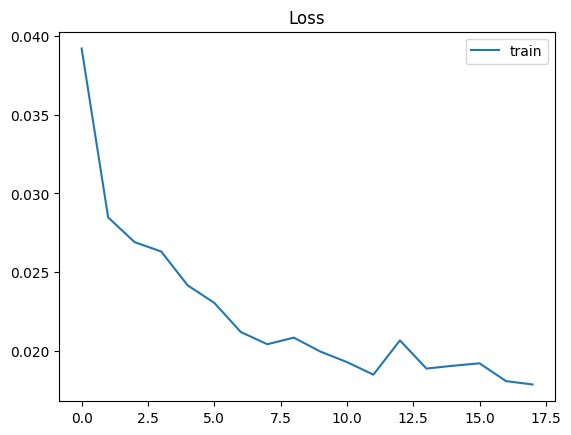

In [ ]:
history = train_simple_model(model, X_train, Y_train)
plot_loss(history)

In [ ]:
last_sequence = train_data_combined_ws_week_scaled_dt[-look_back:].reshape(1, look_back, num_features)
prediction = model.predict(last_sequence, verbose=0)

print(f"Prediction shape: {prediction.shape}")  # (1, features)
print(f"Prediction values: {prediction[0]}")

Prediction shape: (1, 14)
Prediction values: [0.15274656 0.48350808 0.07116527 0.47158864 0.35313505 0.8592758
 0.47835132 0.7553521  0.09293988 0.1059448  0.25958893 0.2589707
 0.90913707 0.84980243]


In [ ]:
prediction_denormalized = scaler_data_combined_ws_week_dt.inverse_transform(prediction)
print(f"Denormalized prediction: {prediction_denormalized[0]}")

Denormalized prediction: [1.1915576e+00 1.9274013e+02 2.4255496e-01 9.4141870e+02 3.9061642e+00
 8.9105606e+01 9.7000469e+03 6.0428166e+00 4.7192150e+01 1.8195061e+01
 2.8947556e+01 8.7691212e+00 1.1000507e+01 2.0213992e+03]


In [ ]:
prediction_denormalized[0][8]

np.float32(47.19215)

In [ ]:
target_prediction = prediction_denormalized[0, index_of_target_feature]
print(f"Target prediction (1 day): {target_prediction}")

Target prediction (1 day): 47.1921501159668


In [ ]:
test_data_combined_ws_week_dt.iloc[0]

,2022-12-06
wind_speed,1.700000
wind_direction,144.458333
precipitation,0.508333
pressure,941.104167
temperature,7.525000
humidity,84.416667
visibility,14489.166667
cloudiness,7.416667
Bjelave_PM10,28.723416
Bjelave_SO2,18.977879


# SHAP Analysis of Multi-horizon LSTM for Direct Multi-step Time Series Prediction

In [49]:
import shap
import numpy as np
import matplotlib.pyplot as plt
"""
# popraviti neke sitnice
background_size = 100
test_size = 50

X_background = X_train_ws_thirty_dt[-background_size:]
print(f"Background data shape: {X_background.shape}")

X_test_shap = X_train_ws_thirty_dt[-test_size-background_size:-background_size]
print(f"Test data for SHAP shape: {X_test_shap.shape}")

explainer = shap.GradientExplainer(
    model_thirty_multivariate_dt,
    X_background
)

print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test_shap)
print(f"SHAP values shape: {np.array(shap_values).shape}")

shap_values_day1 = shap_values[:, :, :, 0]  # (50, 37, 14)
shap_values_avg = np.mean(shap_values, axis=3)  # (50, 37, 14)
print(f"SHAP values for day 1 shape: {shap_values_day1.shape}")
print(f"Average SHAP values shape: {shap_values_avg.shape}")

shap_flat_day1 = shap_values_day1.reshape(test_size, -1)  # (50, 37*14)
shap_flat_avg = shap_values_avg.reshape(test_size, -1)    # (50, 37*14)
X_test_flat = X_test_shap.reshape(test_size, -1)          # (50, 37*14)

try:
    feature_names_original = train_data_combined_ws_thirty_dt.columns.tolist()
except AttributeError:
    feature_names_original = [f'Feature_{i}' for i in range(num_features)]


print(f"Feature names: {feature_names_original}")

feature_names_expanded = []
for t in range(look_back):
    for f in feature_names_original:
        feature_names_expanded.append(f"{f}_t-{look_back-t-1}")

print(f"Number of expanded features: {len(feature_names_expanded)}")


plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_flat_day1,
    X_test_flat,
    feature_names=feature_names_expanded,
    max_display=20,
    show=False
)
plt.title('SHAP Summary - Predikcija za dan 1')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_flat_avg,
    X_test_flat,
    feature_names=feature_names_expanded,
    max_display=20,
    show=False
)
plt.title('SHAP Summary - Usrednjeno preko svih dana')
plt.tight_layout()
plt.show()

time_step_importance = np.mean(np.abs(shap_values_avg), axis=(0, 2))
plt.figure(figsize=(12, 6))
plt.bar(range(look_back), time_step_importance)
plt.title('Važnost po vremenskim koracima (usrednjeno)')
plt.xlabel('Vremenski korak (unazad)')
plt.ylabel('Srednja apsolutna SHAP vrednost')
plt.xticks(range(0, look_back, 5))
plt.show()

feature_importance = np.mean(np.abs(shap_values_avg), axis=(0, 1))
plt.figure(figsize=(10, 6))
plt.bar(feature_names_original, feature_importance)
plt.title('Važnost feature-a (usrednjeno preko vremena)')
plt.xlabel('Feature')
plt.ylabel('Srednja apsolutna SHAP vrednost')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
plt.imshow(shap_values_avg[0].T, cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)
plt.colorbar(label='SHAP vrednost')
plt.title('SHAP vrednosti po vremenu i feature-ima (primer 1)')
plt.xlabel('Vremenski korak (unazad)')
plt.ylabel('Feature')
plt.yticks(range(num_features), feature_names_original)
plt.xticks(range(0, look_back, 5))
plt.tight_layout()
plt.show()

horizon_importance = np.mean(np.abs(shap_values), axis=(0, 1, 2))
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(horizon_importance)+1), horizon_importance, 'o-')
plt.title('Važnost input podataka za različite dane predikcije')
plt.xlabel('Dan predikcije')
plt.ylabel('Srednja apsolutna SHAP vrednost')
plt.grid(True, alpha=0.3)
plt.show()

feature_importance_day1 = np.mean(np.abs(shap_flat_day1), axis=0)
top_indices = np.argsort(feature_importance_day1)[-10:][::-1]
top_features = [feature_names_expanded[i] for i in top_indices]
top_values = feature_importance_day1[top_indices]

plt.figure(figsize=(12, 6))
plt.barh(top_features, top_values)
plt.title('Top 10 najvažnijih feature-a za predikciju dana 1')
plt.xlabel('Srednja apsolutna SHAP vrednost')
plt.tight_layout()
plt.show()

print("SHAP analiza završena!")
print(f"Ukupno feature-a u modelu: {num_features}")
print(f"Lookback period: {look_back}")
print(f"Horizon: {params_mv['horizon']}")
"""

'\n# popraviti neke sitnice\nbackground_size = 100\ntest_size = 50\n\nX_background = X_train_ws_thirty_dt[-background_size:]\nprint(f"Background data shape: {X_background.shape}")\n\nX_test_shap = X_train_ws_thirty_dt[-test_size-background_size:-background_size]\nprint(f"Test data for SHAP shape: {X_test_shap.shape}")\n\nexplainer = shap.GradientExplainer(\n    model_thirty_multivariate_dt,\n    X_background\n)\n\nprint("Calculating SHAP values...")\nshap_values = explainer.shap_values(X_test_shap)\nprint(f"SHAP values shape: {np.array(shap_values).shape}")\n\nshap_values_day1 = shap_values[:, :, :, 0]  # (50, 37, 14)\nshap_values_avg = np.mean(shap_values, axis=3)  # (50, 37, 14)\nprint(f"SHAP values for day 1 shape: {shap_values_day1.shape}")\nprint(f"Average SHAP values shape: {shap_values_avg.shape}")\n\nshap_flat_day1 = shap_values_day1.reshape(test_size, -1)  # (50, 37*14)\nshap_flat_avg = shap_values_avg.reshape(test_size, -1)    # (50, 37*14)\nX_test_flat = X_test_shap.reshape(